In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import pickle as pkl

import glob

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-78, -77, -10.3, -8.5]

#isbuffer = [-74.5, -65, -20, -13] Altiplano

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

In [6]:
era = readERA('u250')
era = era.sel(latitude=slice(isbuffer[2],isbuffer[3]), longitude=slice(isbuffer[0],isbuffer[1])).load().sel(time=((era['time.year']>=1985)&(era['time.year']<=2018)))#.salem.roi(shape=sdf)

In [7]:
eraq8 = readERA('q850')
eraq8 = eraq8.sel(latitude=slice(isbuffer[2],isbuffer[3]), longitude=slice(isbuffer[0],isbuffer[1])).sel(time=((eraq8['time.year']>=1985)&(eraq8['time.year']<=2018))).load()#.salem.roi(shape=sdf)

In [8]:
erav = readERA('v250')
erav = erav.sel(latitude=slice(isbuffer[2],isbuffer[3]), longitude=slice(isbuffer[0],isbuffer[1])).load().sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018)))#.salem.roi(shape=sdf).load()

In [9]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lat=slice(isbuffer[2],isbuffer[3]), lon=slice(isbuffer[0],isbuffer[1]))


In [10]:
ch_on_era = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.daily.peru.nc')
chirps_doypick = ch_on_era.sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(isbuffer[2],isbuffer[3]), longitude=slice(isbuffer[0],isbuffer[1]))
#chirps_bimod = chirps_doypick.salem.roi(shape=sdf) #.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))

In [11]:
# wrf = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/rio_santa_WRF/wrfout*200*.nc', concat_dim='time', data_vars=['PRCP'], combine='nested')
# wrf_doypick = wrf.sel(time=((wrf['time.year']>=1985)&(wrf['time.year']<=2018))).sel(latitude=slice(isbuffer[2],isbuffer[3]), longitude=slice(isbuffer[0],isbuffer[1]))

In [12]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY/*.nc')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(lat=slice(isbuffer[2],isbuffer[3]), lon=slice(isbuffer[0],isbuffer[1]))#.salem.roi(shape=sdf).load()

In [13]:
# regions = {
#     'equatorial' : [(-5,0)],
#     'transition' : [(-8,-5)],
#     'central' : [(-12,-8)],
#     'southern' : [(-18,-15)]}
# h = 2000

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [14]:
posgrid = np.intersect1d(era.time.values, chirps_doypick.time.values)
posgridg = np.intersect1d(chirps_doypick.time.values, tir_doypick.time.values)

u200ca = era.sel(time=posgrid).load()

cau200 = chirps_doypick.sel(time=posgrid).load()
grid200 = tir_doypick.sel(time=posgridg)/100
u200gr = chirps_doypick.sel(time=posgridg)

In [15]:
v850ca = erav.sel(time=posgrid)
q850ca = eraq8.sel(time=posgrid)

In [16]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

In [17]:
grid200 = cau200.salem.transform(grid200)
u200ca = cau200.salem.transform(u200ca)
v200ca = cau200.salem.transform(v850ca)
q850ca = cau200.salem.transform(q850ca)

In [18]:
topo_on_g = cau200.salem.lookup_transform(topo)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

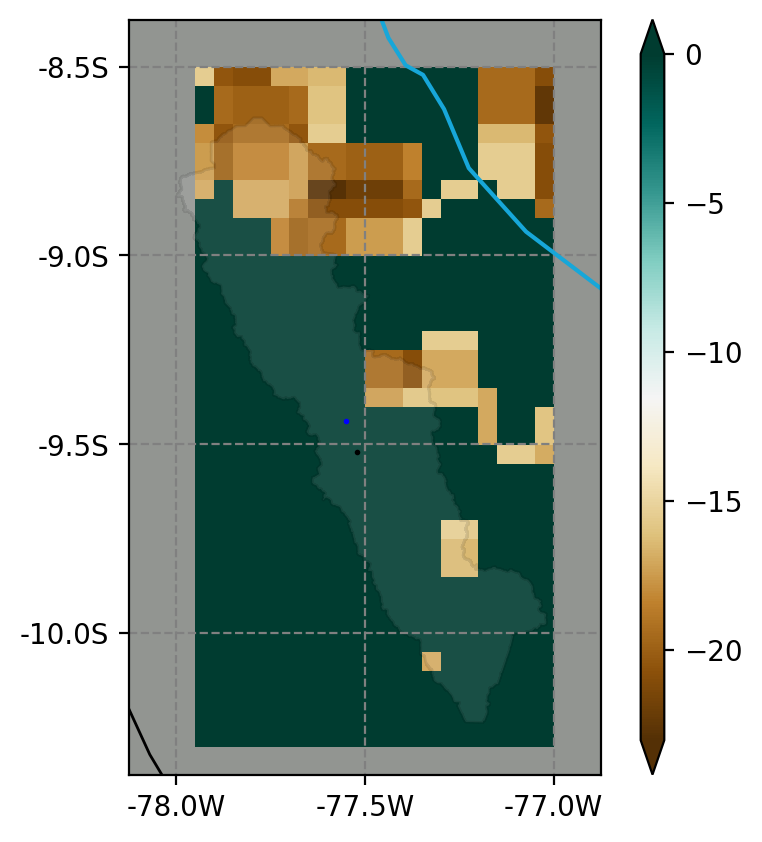

In [19]:
m=1
smap = v850ca.salem.get_map()
f = plt.figure(figsize=(9,5), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(cmap='BrBG', extend='both') #levels=np.linspace(-20, 20, 8)
smap.set_shapefile(rivers=True)
smap.set_shapefile(lakes=True, facecolor='blue', edgecolor='blue')

x, y = smap.grid.transform(-77.52, -9.52)
xx, yy = smap.grid.transform(-77.55, -9.438)

cnt = 0


ax = f.add_subplot(111)
ax.set_facecolor('xkcd:grey')

plt.plot(x, y, 'ko', markersize=1)
plt.plot(xx, yy, 'bo', markersize=1)


#smap.set_data(cau200.sel(time= ((cau200['time.month']==8) & (cau200['time.day']>=1)) | ((cau200['time.month']==9) & (cau200['time.day']<=15))).mean('time')) #np.round(pl*10,2)/mmean*100)
smap.set_data(grid200.sel(time= ((grid200['time.month']==8) & (grid200['time.day']>=1)) | ((grid200['time.month']==9) & (grid200['time.day']<=15))).isel(time=0)) #np.round(pl*10,2)/mmean*100)
#.set_data(v200ca['v'].where(grid200<-15).sel(time= ((v200ca['time.month']==8) & (v200ca['time.day']>=1)) | ((v200ca['time.month']==9) & (v200ca['time.day']<=15))).mean('time').where(topo_on_g<4600))
smap.visualize(ax=ax)

    
plt.tight_layout

In [20]:
import windrose 
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.projections import register_projection

register_projection(WindroseAxes)

In [21]:
wd = np.rad2deg(np.arctan2(u200ca['u'], v200ca['v']))
ws = np.sqrt(v200ca['v']**2 + u200ca['u']**2)

In [22]:
clouds = grid200.sel(time= ((grid200['time.month']==8) & (grid200['time.day']>=15)) | ((grid200['time.month']==9) & (grid200['time.day']<=15))).where(topo_on_g<4500).salem.roi(shape=sdf)
rain = cau200.sel(time= ((wd['time.month']==8) & (wd['time.day']>=15)) | ((wd['time.month']==9) & (wd['time.day']<=15))).where(topo_on_g<4500).salem.roi(shape=sdf)

(array([  78.,   87.,  226.,  370.,  511.,  768.,  933., 1006.,  951.,
         873.,  817.,  764.,  643.,  511.,  394.,  337.,  232.,  197.,
         142.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

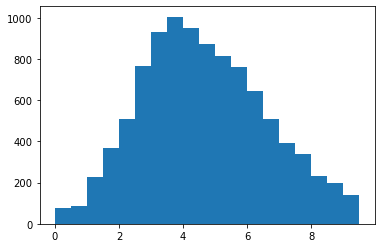

In [23]:
plt.hist(rain.values.flatten()[rain.values.flatten()>0.1], bins=np.arange(0,10,0.5))

In [24]:
# wrfrio = wrf_doypick.sel(time= ((wrf_doypick['time.month']==8) & (wrf_doypick['time.day']>=15)) | ((wrf_doypick['time.month']==9) & (wrf_doypick['time.day']<=15))).salem.roi(shape=sdf)

In [25]:
# wrfrio['PRCP'].mean('time').plot()

In [26]:
#plt.hist(wrfrio['PRCP'].values.flatten()[wrfrio['PRCP'].values.flatten()>0.1], bins=np.arange(0,10,0.5))

(-60.0, -15.0)

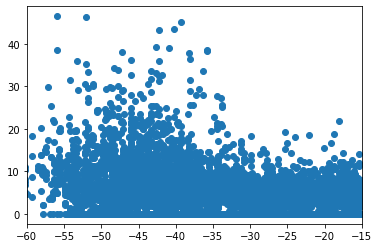

In [27]:
plt.scatter(clouds.values.flatten(), rain.values.flatten())
plt.xlim(-60,-15)

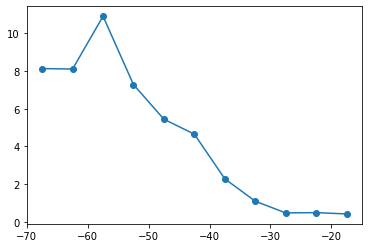

In [28]:
ebins=np.arange(-70,-14,5)
vals, bedge, bnum = stats.binned_statistic(clouds.values.flatten(),rain.values.flatten(), statistic=np.mean, bins=np.arange(-70,-14,5))
cbins = ebins[0:-1]+(ebins[1::]-ebins[0:-1])/2

plt.plot(cbins, vals, marker='o')

cloudy cases 253440
all cases 51744
nb years 11


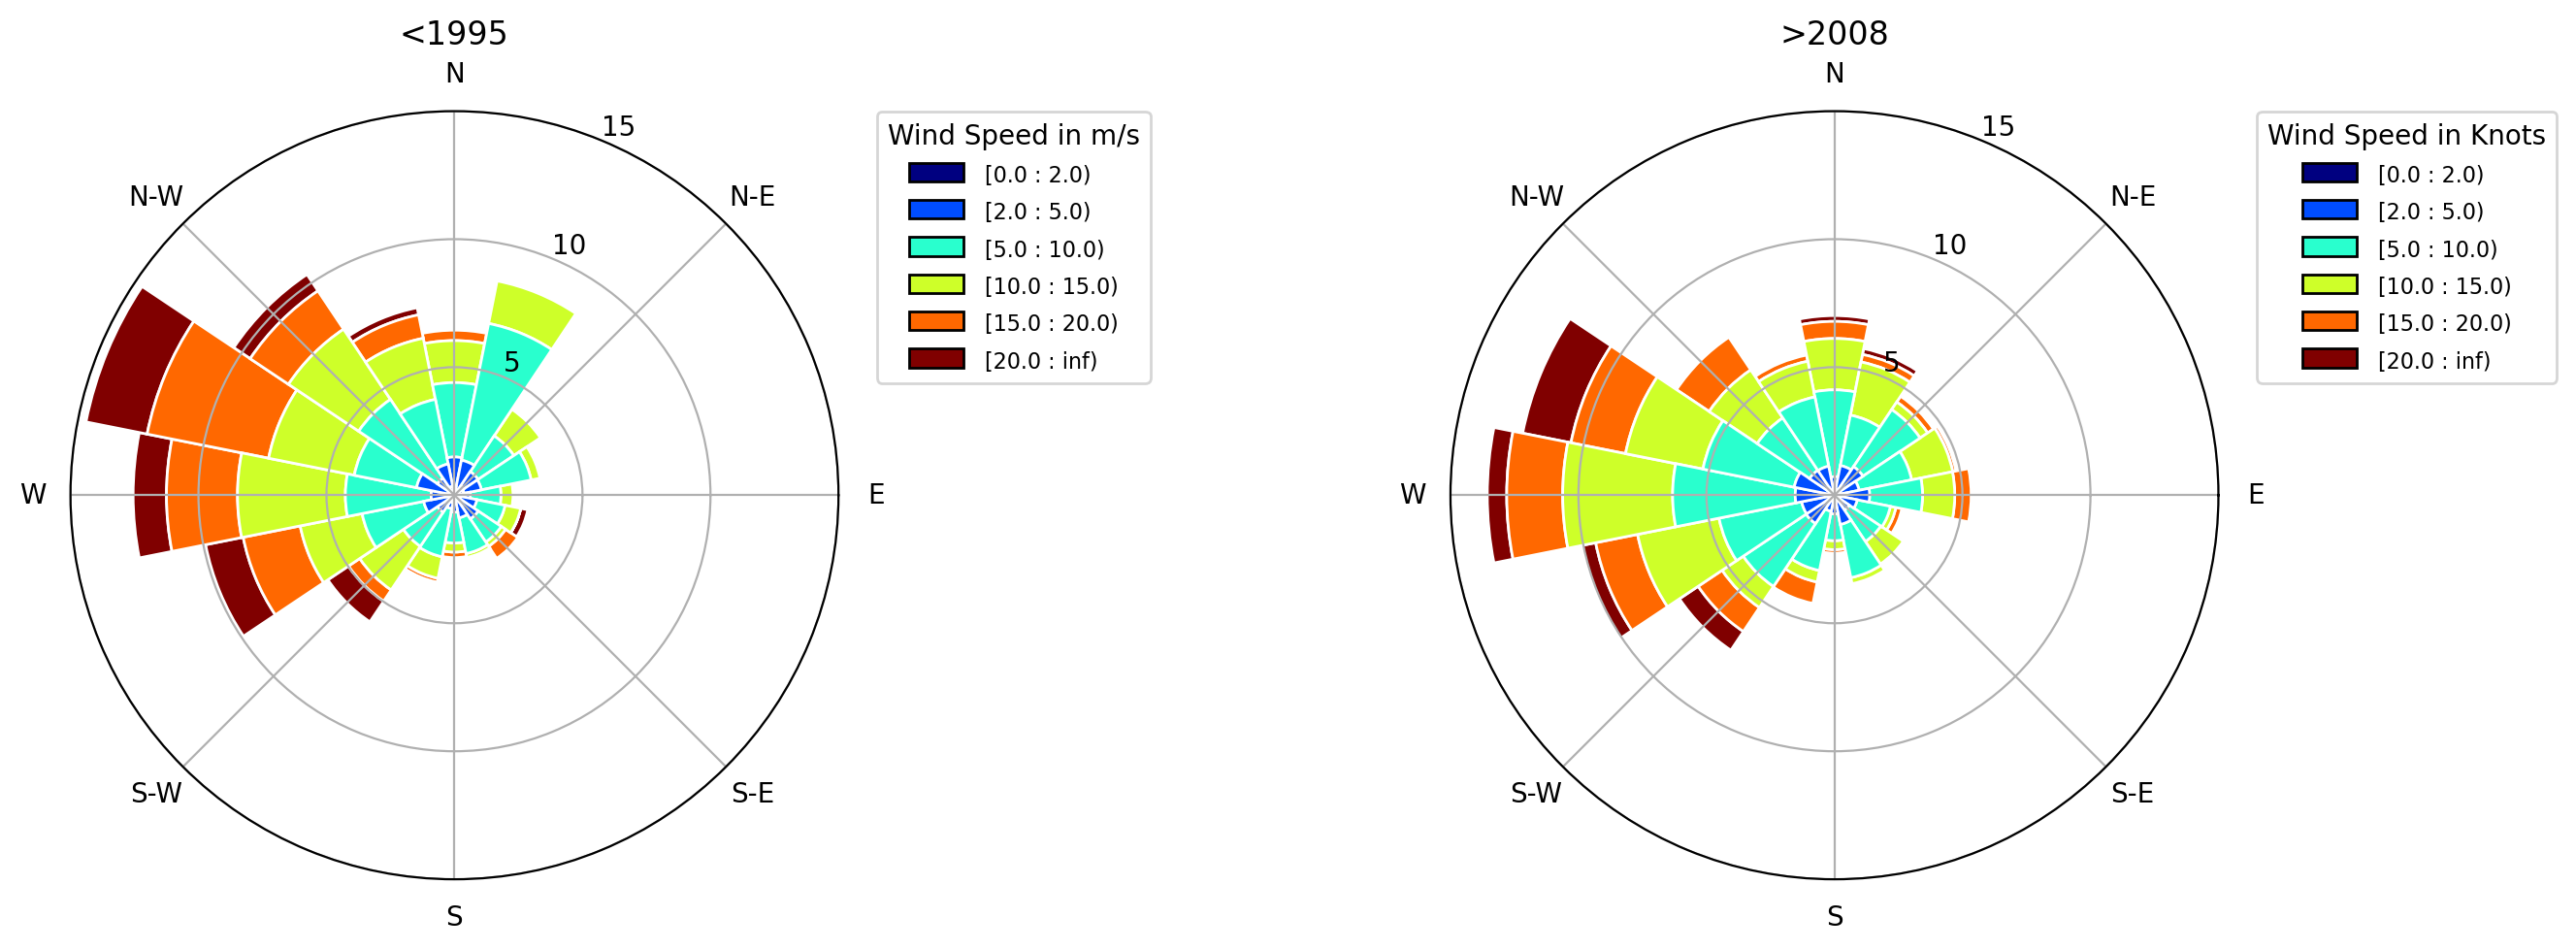

In [29]:
f = plt.figure(figsize=(15,5), dpi=200)

y1 = 1995
y2 = 2008

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=y1)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=y1)).where(topo_on_g<4500).salem.roi(shape=sdf)

wdaug2 = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']>=y2)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug2 = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']>=y2)).where(topo_on_g<4500).salem.roi(shape=sdf)

ax = f.add_subplot(1,2,1, projection='windrose')

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]

ws_array2 = np.array(wsaug2.values.flatten())
wd_array2 = np.array(wdaug2.values.flatten())

ws_array2 = ws_array2[np.isfinite(ws_array2)]
wd_array2 = wd_array2[np.isfinite(wd_array2)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))

ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
plt.title('<'+str(y1))


ax = f.add_subplot(1,2,2, projection='windrose')

alim = -15 #puspa
blim = -30

# alim = -30
# blim = -100

wdin = wdaug2.values
wsin = wsaug2.values

print('cloudy cases', wdin.size)
print('all cases', ws_array.size)
print('nb years', np.unique(wdaug['time.year']).size)

ws_array2 = np.array(wsin.flatten())
wd_array2 = np.array(wdin.flatten())

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
plt.title('>'+str(y2))


ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
# if mon == 1:
#     plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-20.jpg')

cloudy cases puspa 2155
all cases 184926
nb years 34
cloudy cases deep 3020


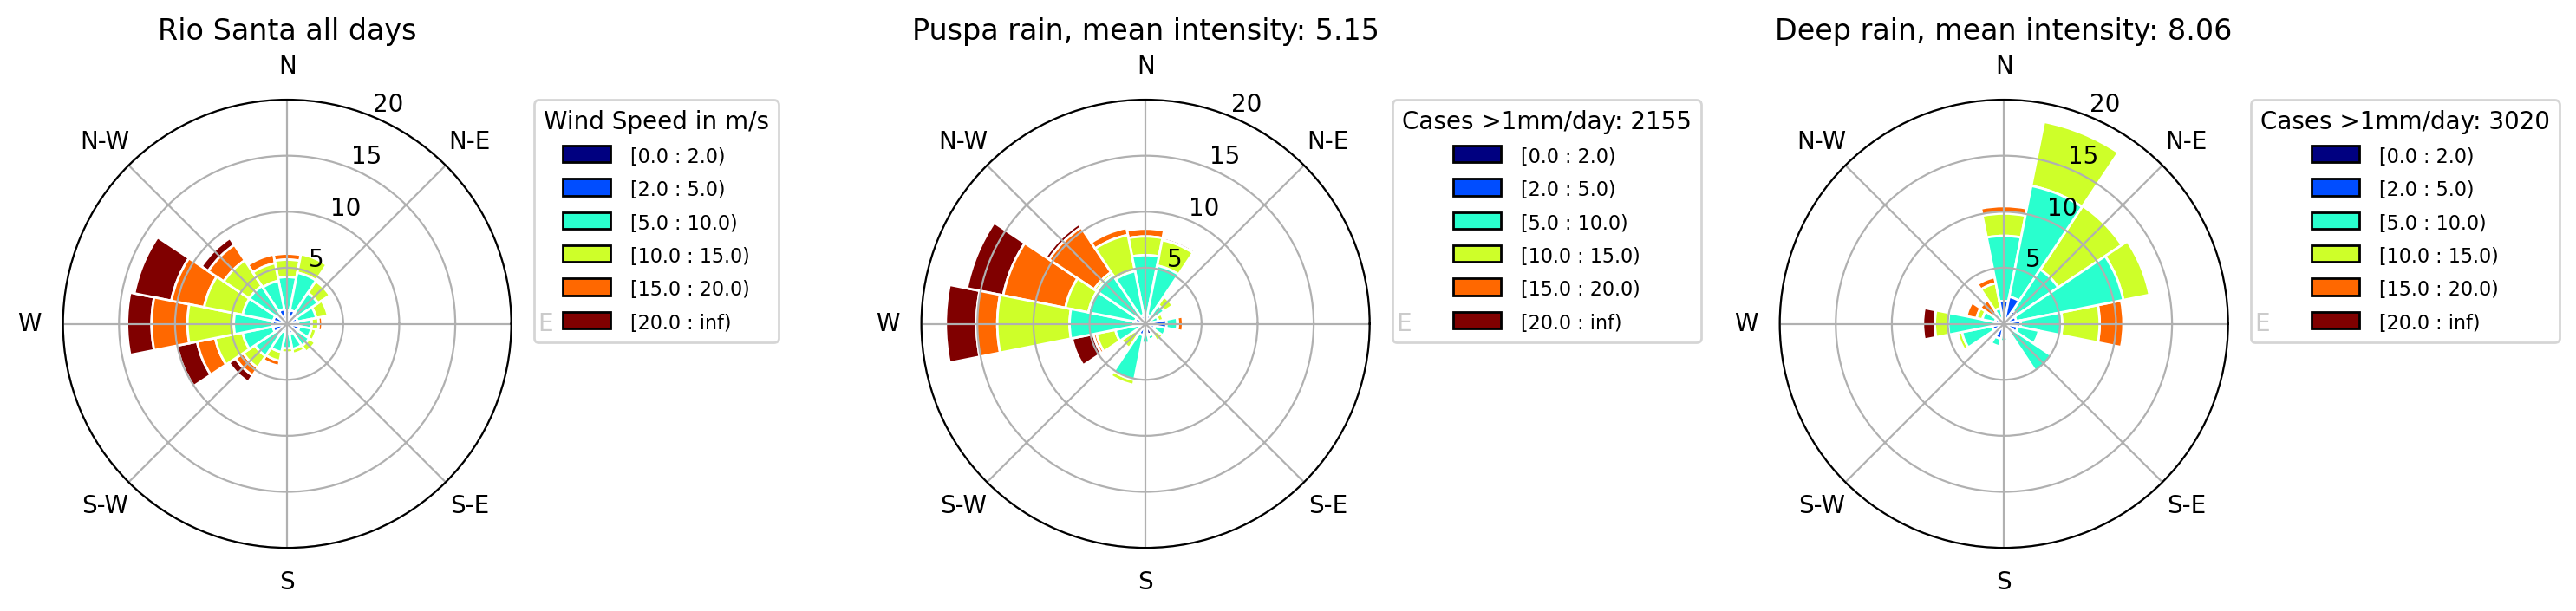

In [30]:
f = plt.figure(figsize=(15,5), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=10) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=10) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=10) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=10) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
ax = f.add_subplot(1,3,1, projection='windrose')

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 25, step=5))
ax.set_yticklabels(np.arange(5, 25, step=5))

ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
plt.title('Rio Santa all days')


ax = f.add_subplot(1,3,2, projection='windrose')

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70

wdin = wdaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]
wsin = wsaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]



print('cloudy cases puspa', wdin.size)
print('all cases', ws_array.size)
print('nb years', np.unique(wdaug['time.year']).size)

ws_array = np.array(wsin.flatten())
wd_array = np.array(wdin.flatten())

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 25, step=5))
ax.set_yticklabels(np.arange(5, 25, step=5))
plt.title('Puspa rain, mean intensity: '+str(np.round(np.nanmean(caaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]),2)))
ax.set_legend(title = 'Cases >1mm/day: '+str(wdin.size), bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0.)


ax = f.add_subplot(1,3,3, projection='windrose')

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -70

wdin = wdaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]
wsin = wsaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]



print('cloudy cases deep', wdin.size)

ws_array = np.array(wsin.flatten())
wd_array = np.array(wdin.flatten())

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 25, step=5))
ax.set_yticklabels(np.arange(5, 25, step=5))
plt.title('Deep rain, mean intensity: '+str(np.round(np.nanmean(caaug.values[(graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)]),2)))


ax.set_legend(title = 'Cases >1mm/day: '+str(wdin.size), bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0.)
# if mon == 1:
#     plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-30_3x.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


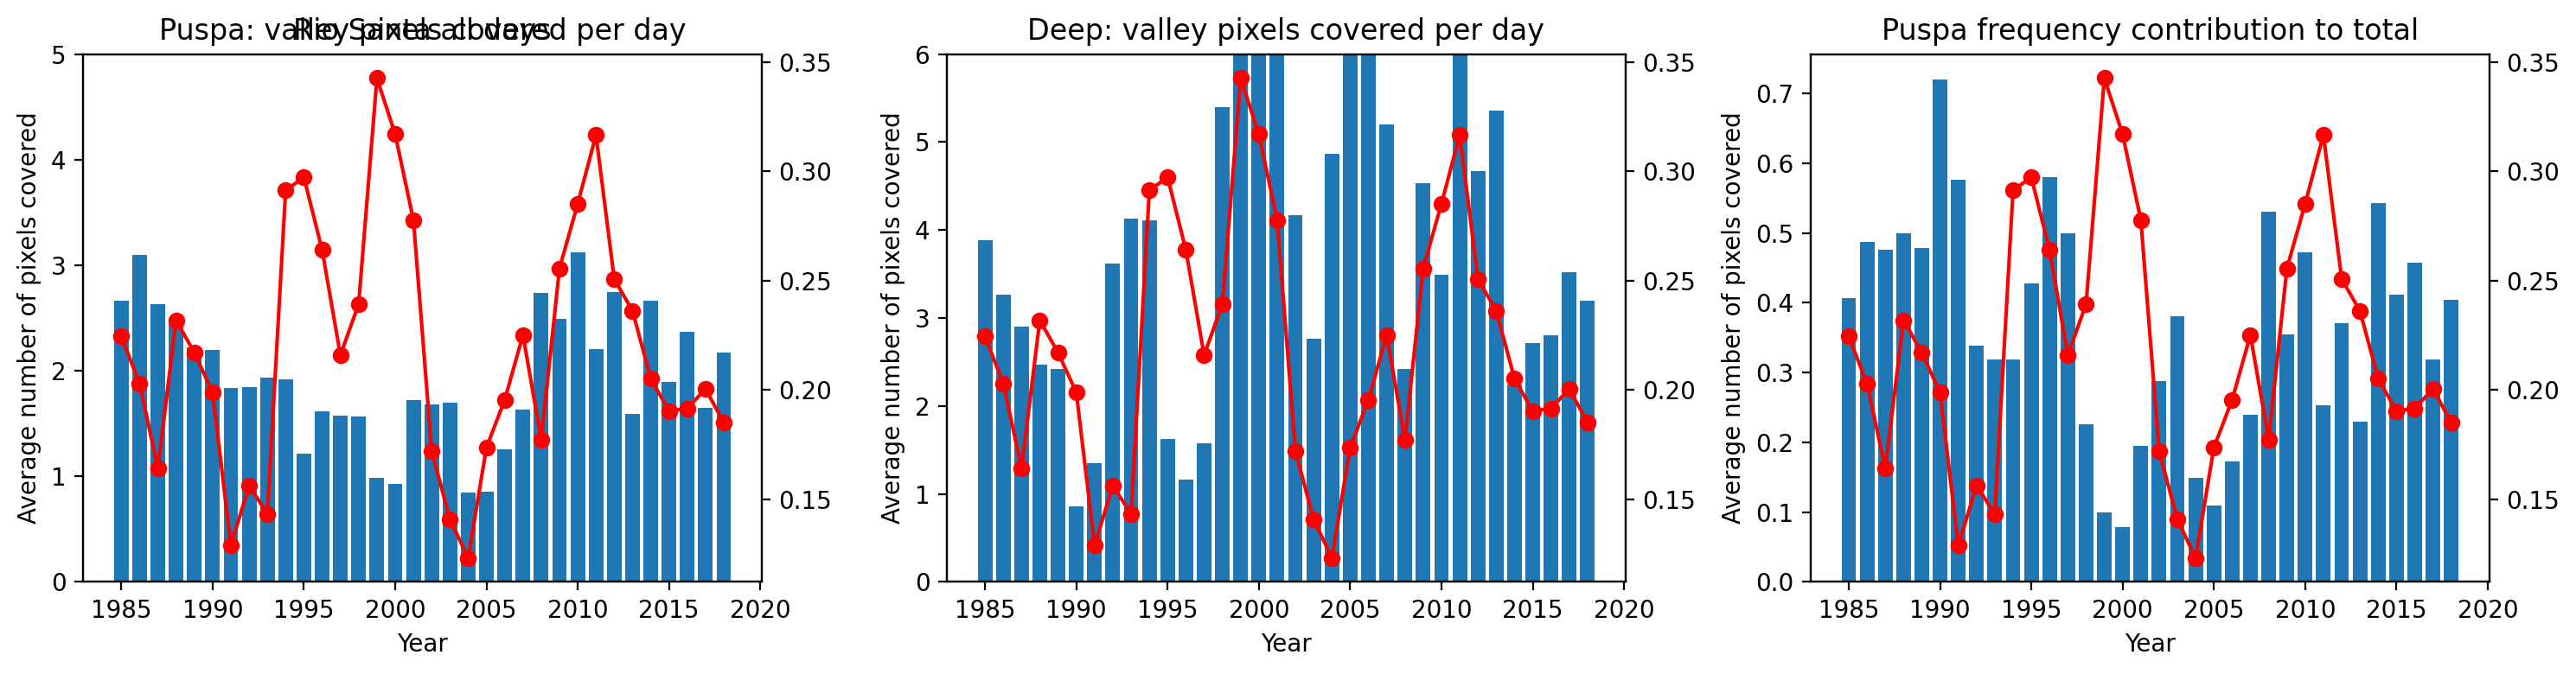

In [31]:
f = plt.figure(figsize=(15,4), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=30))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=30))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=30))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=30))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
uaug = wd.sel(time= ((wd['time.month']==8)| (wd['time.month']==9) ) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180 #u200ca['u'].sel(time=(((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=30))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)

ax = f.add_subplot(1,3,1)

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

plt.title('Rio Santa all days')


ax = f.add_subplot(1,3,1)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70
allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

uin = uaug.where((uaug>=0) & (uaug<=90)).groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()/uaug.groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()

# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())
uin_array = np.array(uin.values.flatten())


ax.bar(wdin.year, ws_array)
ax2 = ax.twinx()
ax2.plot(wdin.year, uin_array, color='r', marker='o')

ax.set_ylabel('Average number of pixels covered')
plt.title('Puspa: valley pixels covered per day')
ax.set_xlabel('Year')
ax.set_ylim(0,5)


ax = f.add_subplot(1,3,2)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -80

wdinD = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsinD = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude']).rolling(year=3, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size



# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_arrayD = np.array(wsinD.values.flatten())
wd_arrayD = np.array(wdinD.values.flatten())

ax.bar(wdin.year, ws_arrayD)
ax2 = ax.twinx()
ax2.plot(wdin.year, uin_array, color='r', marker='o')

ax.set_ylabel('Average number of pixels covered')
plt.title('Deep: valley pixels covered per day')
ax.set_xlabel('Year')
ax.set_ylim(0,6)

ax = f.add_subplot(1,3,3)

ax.bar(wdin.year, ws_array/(ws_array+wd_arrayD))
ax2 = ax.twinx()
ax2.plot(wdin.year, uin_array, color='r', marker='o')
ax.set_ylabel('Average number of pixels covered')
ax.set_xlabel('Year')


plt.title('Puspa frequency contribution to total')


plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/puspa_annual_CHIRPS_GRIDSAT.jpg')

doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: R

doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


doing 2005
doing 2006
doing 2007
doing 2008
doing 2009


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


doing 2010
doing 2011
doing 2012
doing 2013
doing 2014
doing 2015
doing 2016


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


doing 2017
doing 2018


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


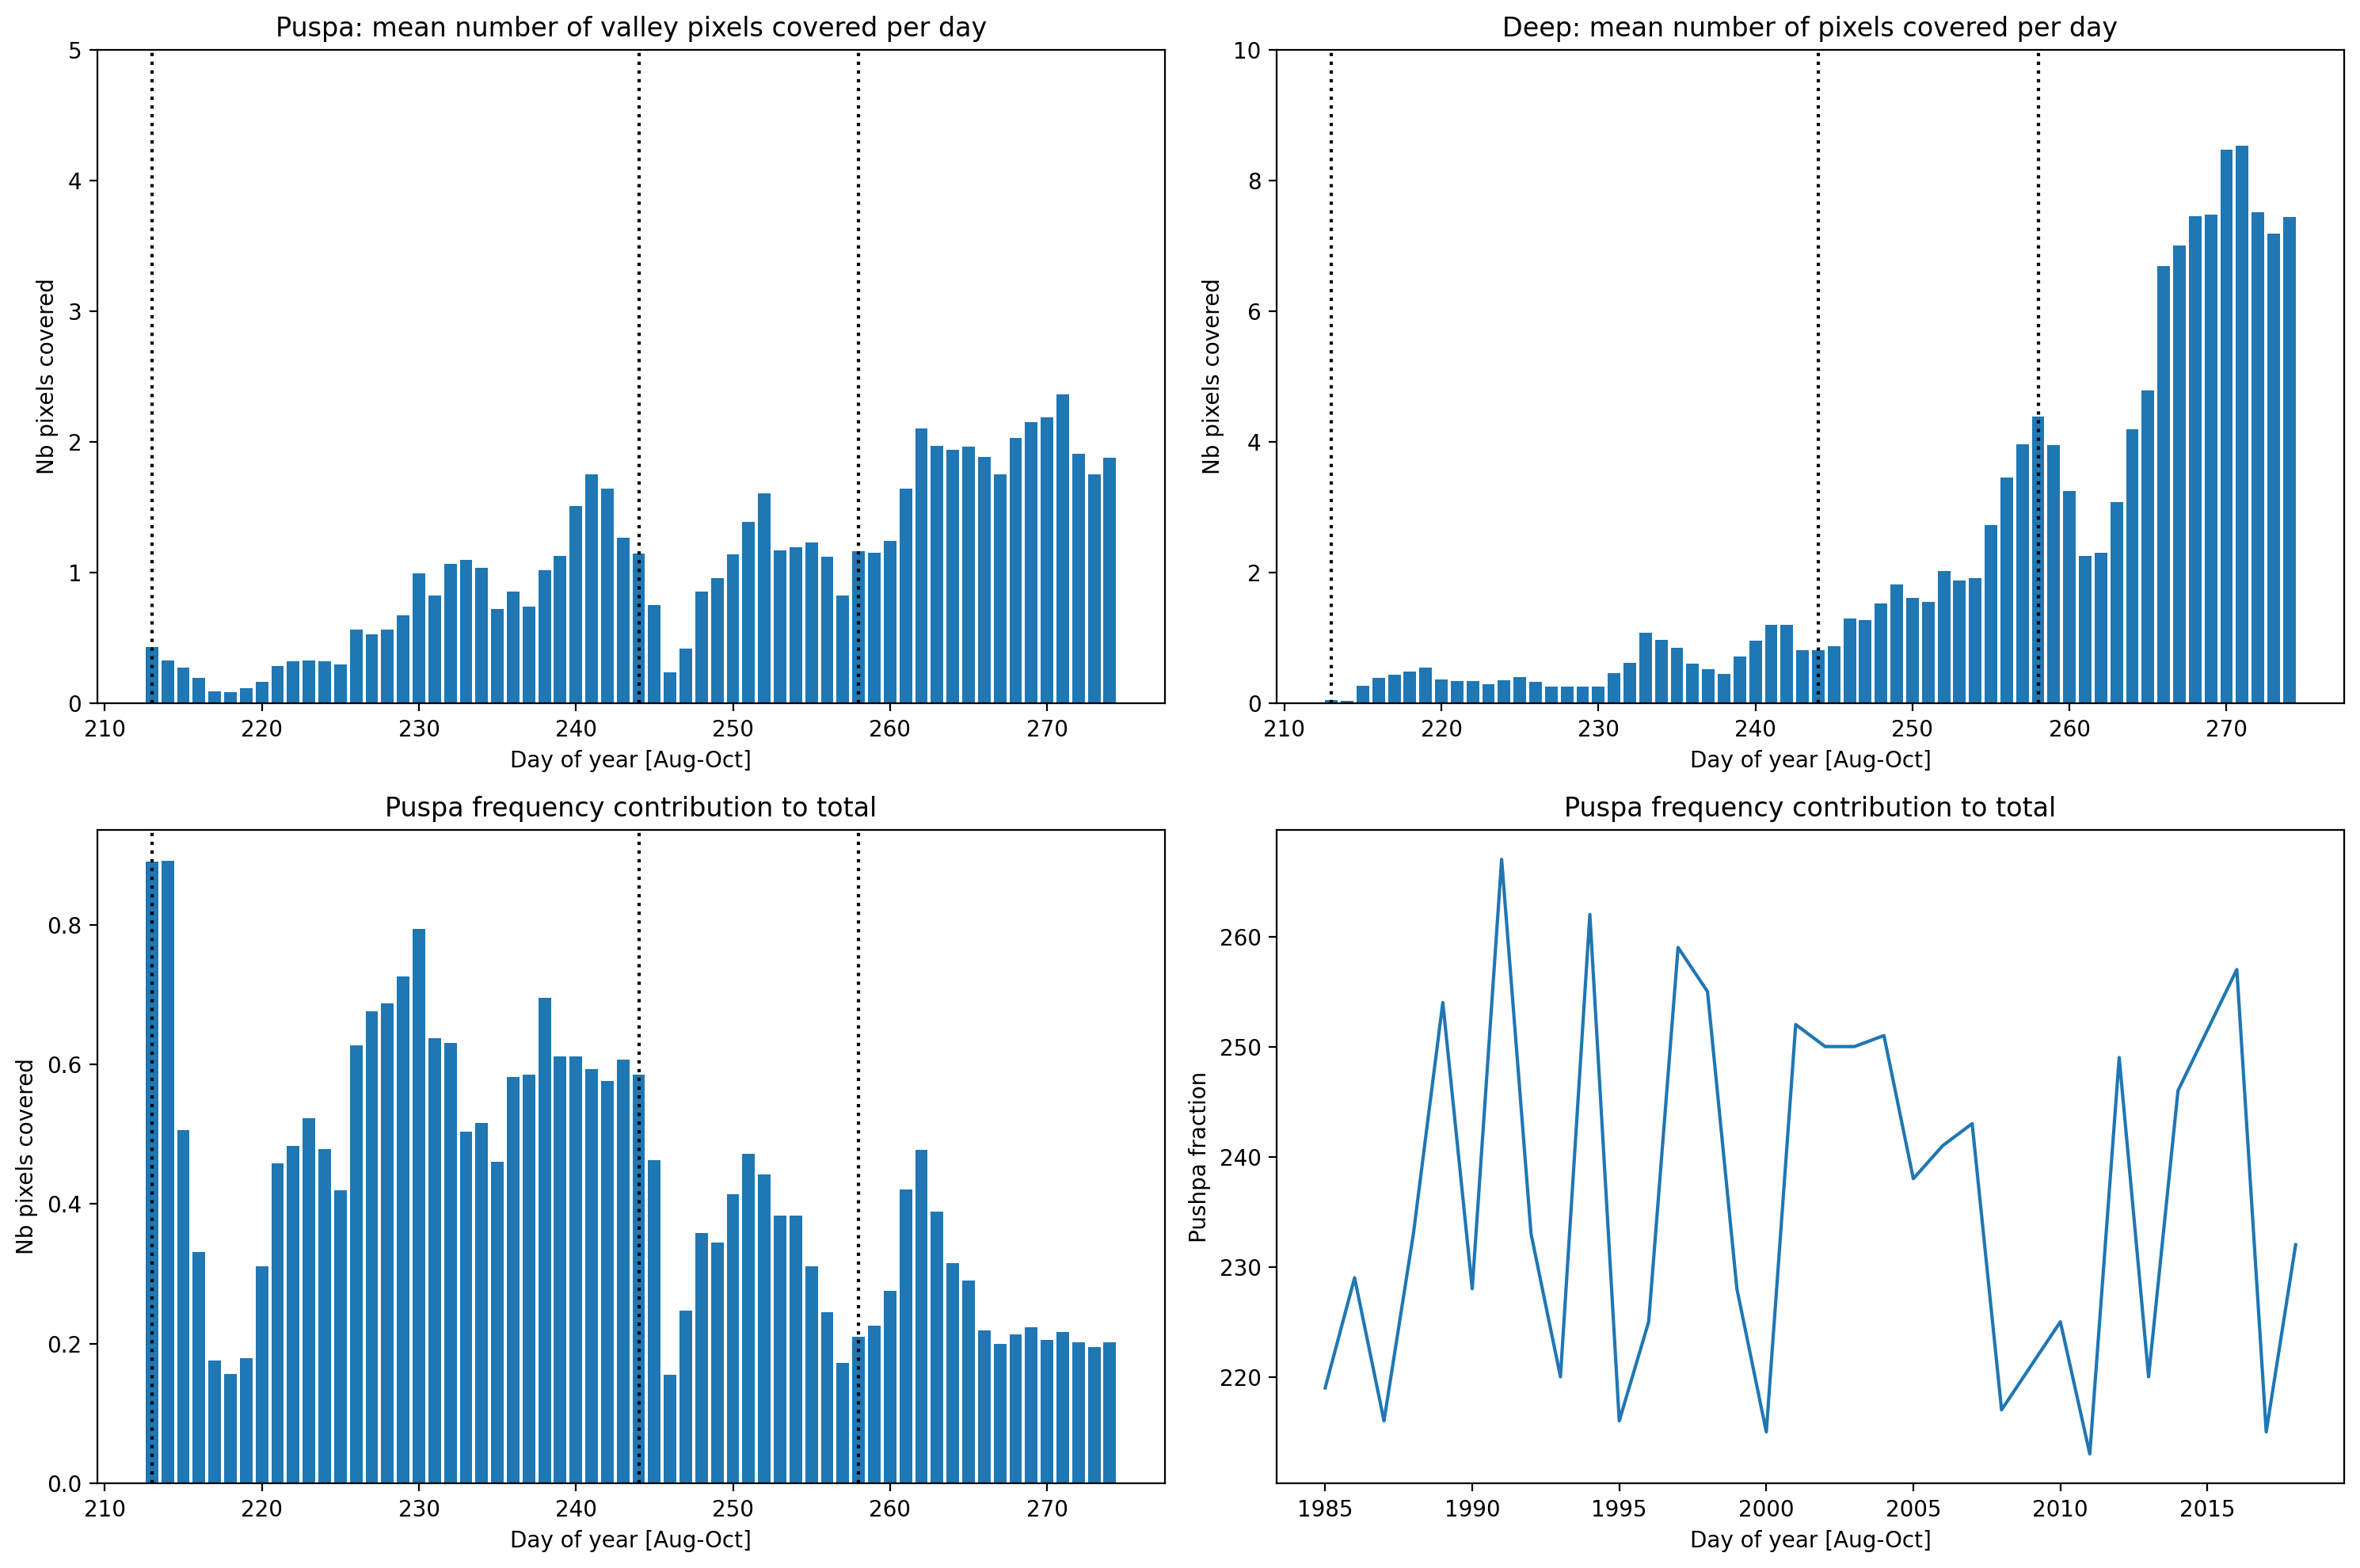

In [34]:
f = plt.figure(figsize=(15,10), dpi=200)

wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<10))) & (wd['time.year']>=1985)& (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<10))) & (wd['time.year']>=1985)& (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<10))) & (wd['time.year']>=1985)& (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)


ws_array = np.array(wsaug.values.flatten())
ws_array = ws_array[np.isfinite(ws_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']


ax = f.add_subplot(2,2,1)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70
allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

ws_array = np.array(wsin.values.flatten())


ax.bar(wsin.dayofyear, ws_array)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
plt.title('Puspa: mean number of valley pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylim(0,5)


ax = f.add_subplot(2,2,2)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -80

wsinD = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
ws_arrayD = np.array(wsinD.values.flatten())


ax.bar(wsin.dayofyear, ws_arrayD)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
plt.title('Deep: mean number of pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylabel('Nb pixels covered')
ax.set_ylim(0,10)


ax = f.add_subplot(2,2,3)
ax.bar(wsin.dayofyear, ws_array/(ws_array+ws_arrayD))
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
# ax.axvline(227, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
ax.set_xlabel('Day of year [Aug-Oct]')

plt.title('Puspa frequency contribution to total')

ax = f.add_subplot(2,2,4)

doy_list = []
fraction_list = []
years = []

for yy in range(1985,2019):
    
    print('doing', yy)
    
   # allpix = wsaug.sel(time=wsaug['time.year']==y).where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
    wsiny = wsaug.sel(time=wsaug['time.year']==yy)
    graugy = graug.sel(time=graug['time.year']==yy)
    caaugy = caaug.sel(time=caaug['time.year']==yy)
    #ipdb.set_trace()
    alim = -15 #puspa
    blim = -30
    wsin = wsiny.where((graugy.values<=alim) & (graugy.values>=blim)  & (caaugy.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wsiny['time.dayofyear']).size

    ws_array = np.array(wsin.values.flatten())
    
    dlim = 1

    alim = -30
    blim = -80

    wsinD = wsiny.where((graugy.values<=alim) & (graugy.values>=blim)  & (caaugy.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wsiny['time.dayofyear']).size

    ws_arrayD = np.array(wsinD.values.flatten())

    
    yfrac = ws_array/(ws_array+ws_arrayD)
   # ipdb.set_trace()
    fpos = np.where(yfrac<=0.5)
    try:
        doy_list.append(wsinD.dayofyear.values[fpos[0][0]])
    except:
        continue
    fraction_list.append(np.nanmean(yfrac))
    years.append(yy)
    
#ipdb.set_trace()
ax.plot(years, doy_list)
ax.set_ylabel('Pushpa fraction')
ax.set_xlabel('Day of year [Aug-Oct]')

plt.title('Puspa frequency contribution to total')


plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/puspa_seasonal_CHIRPS_GRIDSAT_2000-2010.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

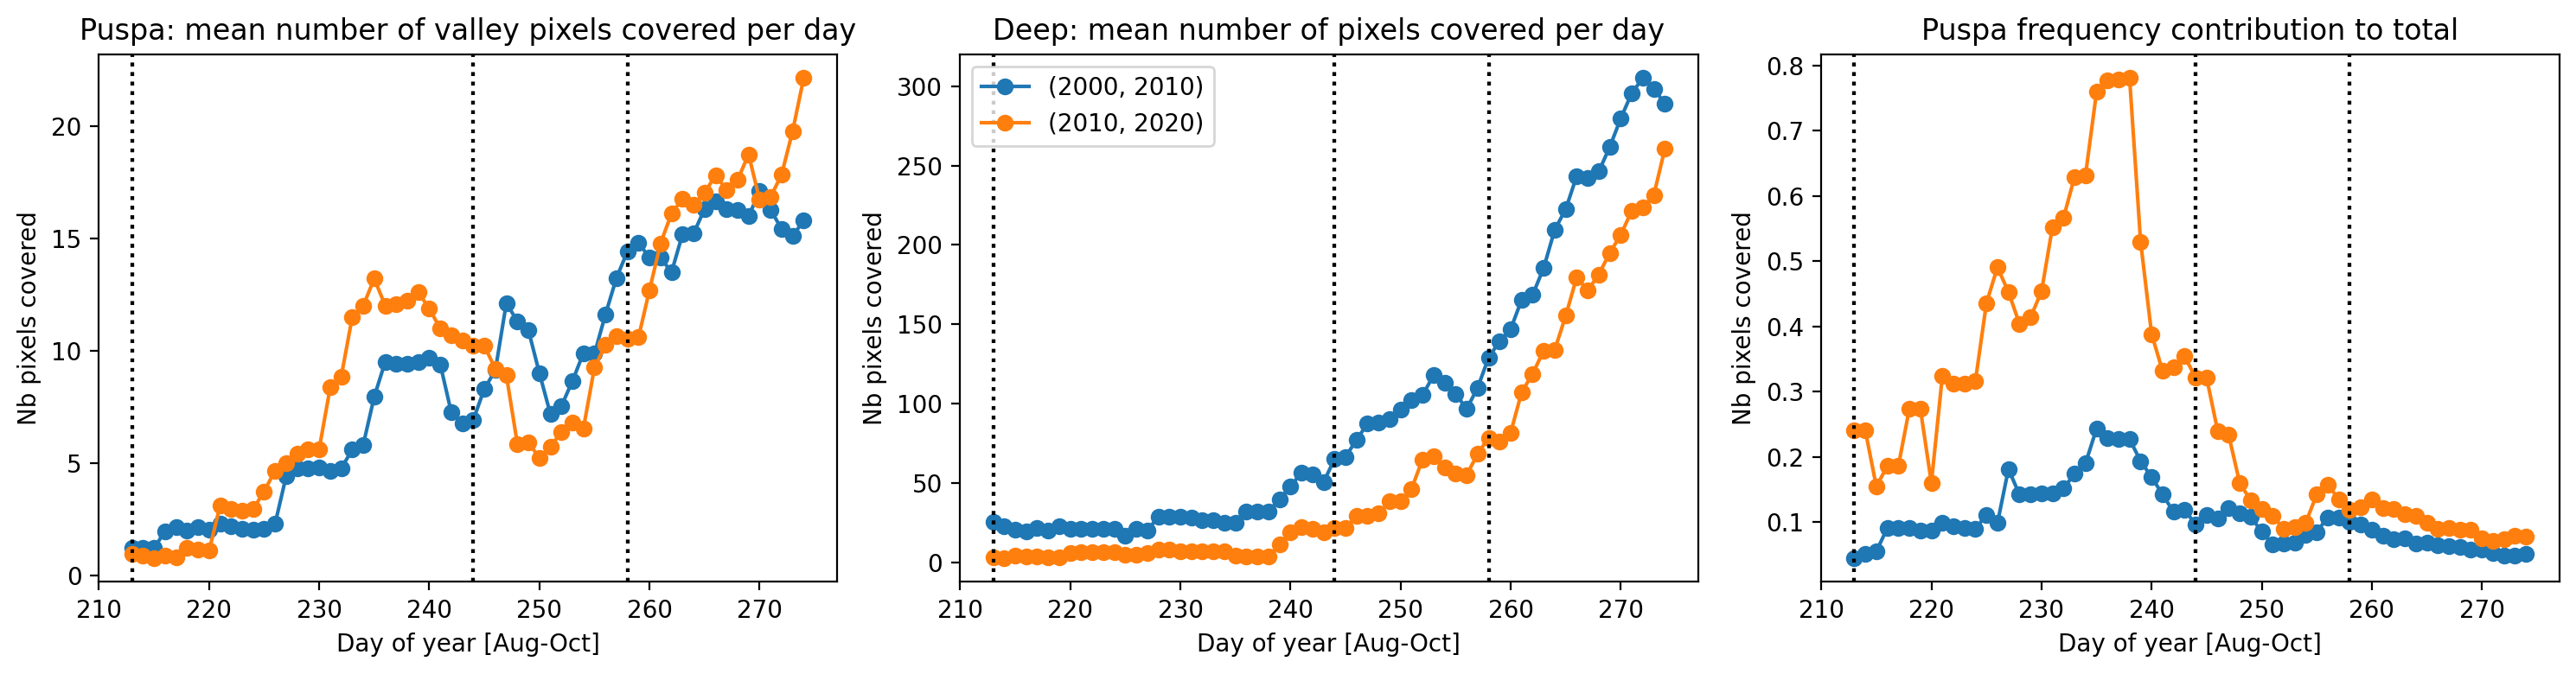

In [39]:
f = plt.figure(figsize=(15,4), dpi=200)

# wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
# wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
# graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
# caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)

for yy in [(2000,2010), (2010,2020)]:  #(1985,1990), (1990,2000), 

    wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']>=yy[0])& (wd['time.year']<=yy[1])).where(topo_on_g<4500).salem.roi(shape=sdf)+180
    wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=9))) & (wd['time.year']>=yy[0])& (wd['time.year']<=yy[1])).where(topo_on_g<4500).salem.roi(shape=sdf)
    graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']>=yy[0])& (wd['time.year']<=yy[1])).where(topo_on_g<4500).salem.roi(shape=sdf)
    caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']>=yy[0])& (wd['time.year']<=yy[1])).where(topo_on_g<4500).salem.roi(shape=sdf)



    ws_array = np.array(wsaug.values.flatten())
    wd_array = np.array(wdaug.values.flatten())

    ws_array = ws_array[np.isfinite(ws_array)]
    wd_array = wd_array[np.isfinite(wd_array)]


    color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']


    ax = f.add_subplot(1,3,1)

    alim = -15 #puspa
    blim = -30

    dlim = 1

    # alim = -30
    # blim = -70
    allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
    wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=15, min_periods=2, center=True).mean()/(np.unique(wdaug['time.dayofyear']).size+wdaug.mean('time').count())
    wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=15, min_periods=2, center=True).mean()/(np.unique(wdaug['time.dayofyear']).size+wdaug.mean('time').count())

    # wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
    # wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

    ws_array = np.array(wsin.values.flatten())
    wd_array = np.array(wdin.values.flatten())


    ax.plot(wdin.dayofyear, ws_array*100, marker='o')
    ax.axvline(213, linestyle='dotted', color='k')
    ax.axvline(244, linestyle='dotted', color='k')
    ax.axvline(258, linestyle='dotted', color='k')
    ax.set_ylabel('Nb pixels covered')
    plt.title('Puspa: mean number of valley pixels covered per day')
    ax.set_xlabel('Day of year [Aug-Oct]')
    #ax.set_ylim(0,4)


    ax = f.add_subplot(1,3,2)

    # alim = -15 #puspa
    # blim = -30

    dlim = 1

    alim = -30
    blim = -80

    wdinD = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=15, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
    wsinD = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=15, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

    # wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
    # wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

    ws_arrayD = np.array(wsinD.values.flatten())
    wd_arrayD = np.array(wdinD.values.flatten())

    ax.plot(wdin.dayofyear, ws_arrayD*100, marker='o', label=str(yy))
    #ax.bar(wdin.dayofyear, ws_arrayD)
    ax.axvline(213, linestyle='dotted', color='k')
    ax.axvline(244, linestyle='dotted', color='k')
    ax.axvline(258, linestyle='dotted', color='k')
    plt.title('Deep: mean number of pixels covered per day')
    ax.set_xlabel('Day of year [Aug-Oct]')
    ax.set_ylabel('Nb pixels covered')
    #ax.set_ylim(0,4)
    
    plt.legend(loc='upper left')

    ax = f.add_subplot(1,3,3)
    ax.plot(wdin.dayofyear, ws_array/(ws_array+wd_arrayD), marker='o')
    #ax.bar(wdin.dayofyear, ws_array/(ws_array+wd_arrayD))
    ax.axvline(213, linestyle='dotted', color='k')
    ax.axvline(244, linestyle='dotted', color='k')
    # ax.axvline(227, linestyle='dotted', color='k')
    ax.axvline(258, linestyle='dotted', color='k')
    ax.set_ylabel('Nb pixels covered')
    ax.set_xlabel('Day of year [Aug-Oct]')

    plt.title('Puspa frequency contribution to total')


plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/puspa_seasonal_CHIRPS_GRIDSAT_perDecades.jpg')

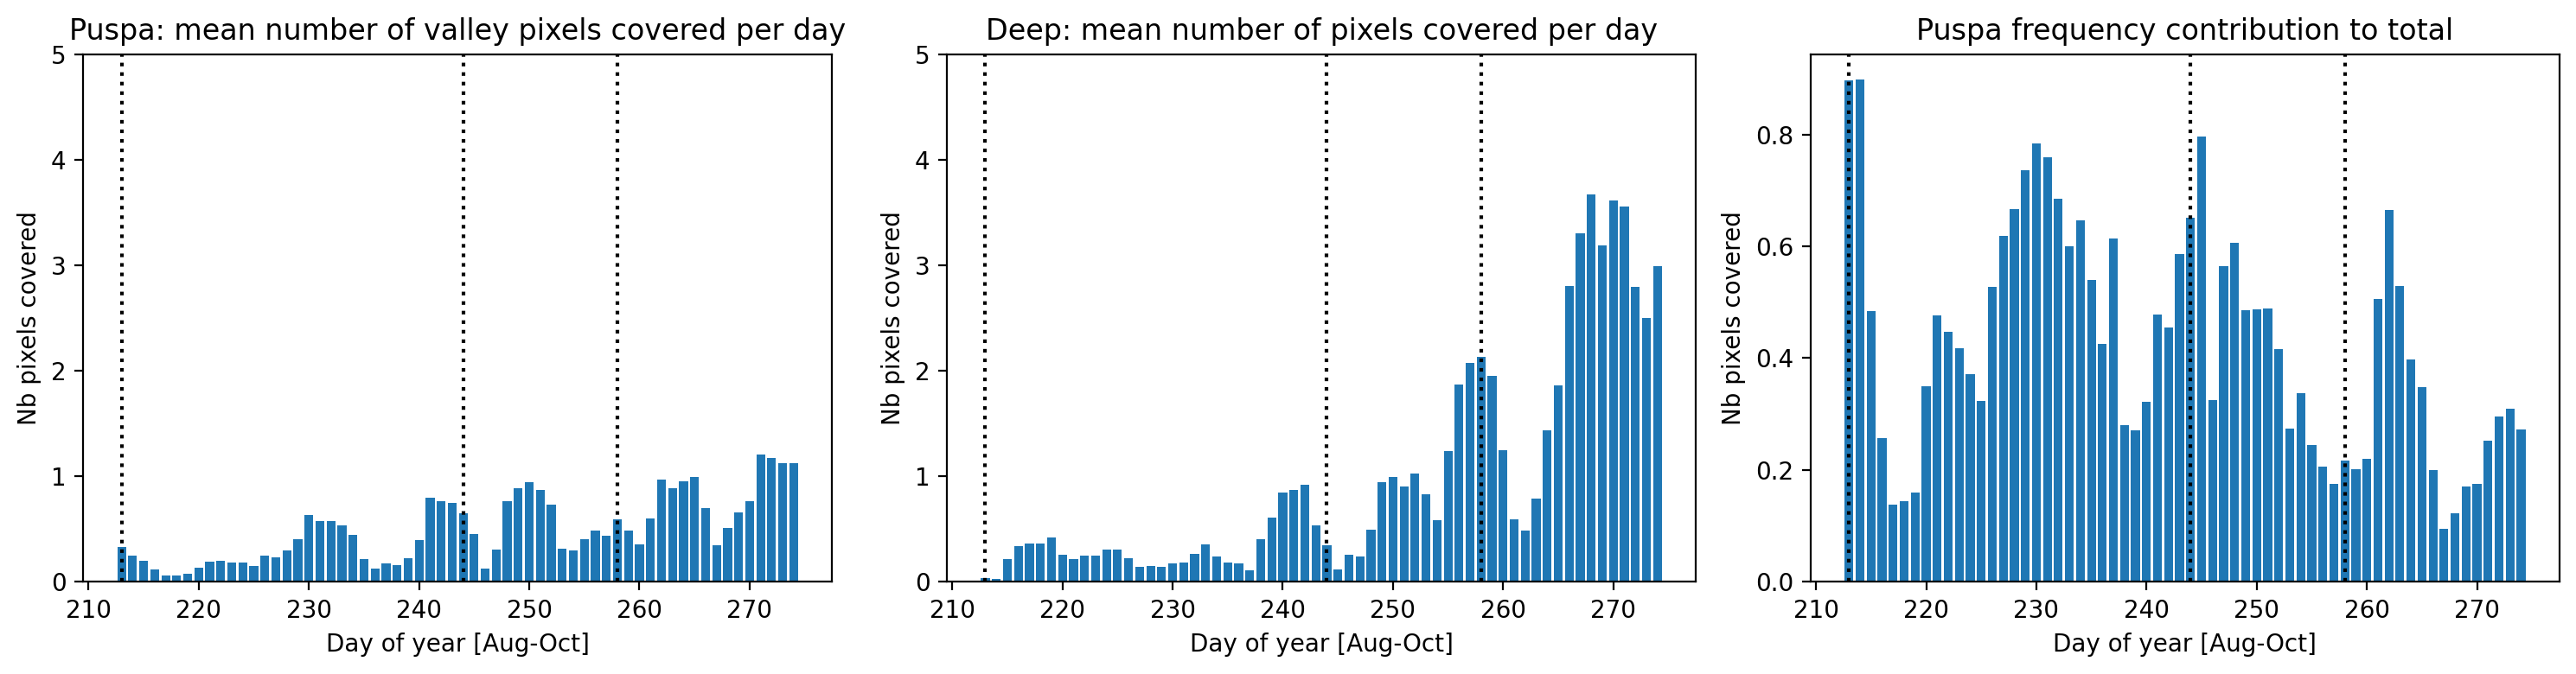

In [35]:
f = plt.figure(figsize=(15,4), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']<=2000)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=9))) & (wd['time.year']<=2000)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']<=2000)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=9))) & (wd['time.year']<=2000)).where(topo_on_g<4500).salem.roi(shape=sdf)

# wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
# wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)
# graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)
# caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)



ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']


ax = f.add_subplot(1,3,1)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70
allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())


ax.bar(wdin.dayofyear, ws_array)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
plt.title('Puspa: mean number of valley pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylim(0,5)



ax = f.add_subplot(1,3,2)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -80

wdinD = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsinD = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_arrayD = np.array(wsinD.values.flatten())
wd_arrayD = np.array(wdinD.values.flatten())


ax.bar(wdin.dayofyear, ws_arrayD)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
plt.title('Deep: mean number of pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylabel('Nb pixels covered')
ax.set_ylim(0,5)


ax = f.add_subplot(1,3,3)
ax.bar(wdin.dayofyear, ws_array/(ws_array+wd_arrayD))
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
# ax.axvline(227, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
ax.set_xlabel('Day of year [Aug-Oct]')

plt.title('Puspa frequency contribution to total')


plt.tight_layout()
plt.show()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/puspa_seasonal_CHIRPS_GRIDSAT_2000.jpg')

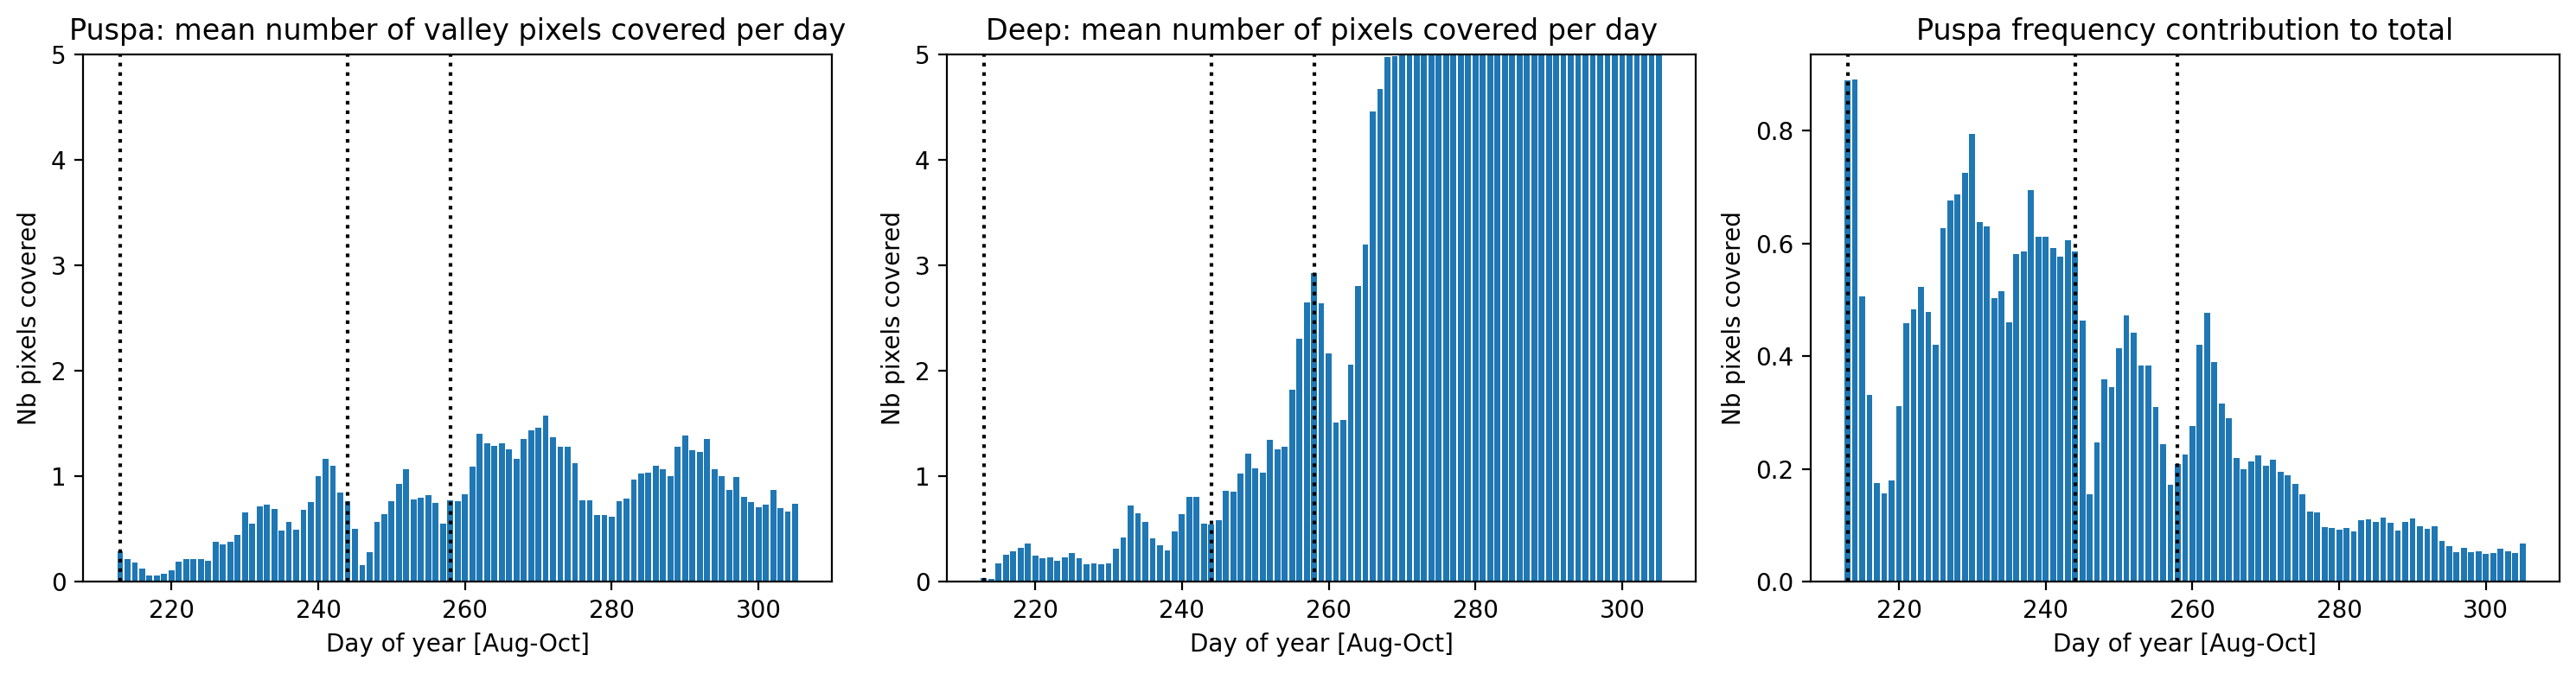

In [34]:
f = plt.figure(figsize=(15,4), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)

# wdaug = wd.sel(time= (((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
# wsaug = ws.sel(time= (((wd['time.month']>=8)  ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)
# graug = grid200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)
# caaug = cau200.sel(time=(((wd['time.month']>=8) ) & ((wd['time.month']<=10))) & (wd['time.year']>=2000)& (wd['time.year']<=2010)).where(topo_on_g<4500).salem.roi(shape=sdf)



ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']


ax = f.add_subplot(1,3,1)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70
allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())


ax.bar(wdin.dayofyear, ws_array)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
plt.title('Puspa: mean number of valley pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylim(0,5)



ax = f.add_subplot(1,3,2)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -80

wdinD = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size
wsinD = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude']).rolling(dayofyear=5, min_periods=2, center=True).mean()/np.unique(wdaug['time.dayofyear']).size

# wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
# wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_arrayD = np.array(wsinD.values.flatten())
wd_arrayD = np.array(wdinD.values.flatten())


ax.bar(wdin.dayofyear, ws_arrayD)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
plt.title('Deep: mean number of pixels covered per day')
ax.set_xlabel('Day of year [Aug-Oct]')
ax.set_ylabel('Nb pixels covered')
ax.set_ylim(0,5)


ax = f.add_subplot(1,3,3)
ax.bar(wdin.dayofyear, ws_array/(ws_array+wd_arrayD))
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
# ax.axvline(227, linestyle='dotted', color='k')
ax.axvline(258, linestyle='dotted', color='k')
ax.set_ylabel('Nb pixels covered')
ax.set_xlabel('Day of year [Aug-Oct]')

plt.title('Puspa frequency contribution to total')


plt.tight_layout()
plt.show()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/puspa_seasonal_CHIRPS_GRIDSAT.jpg')

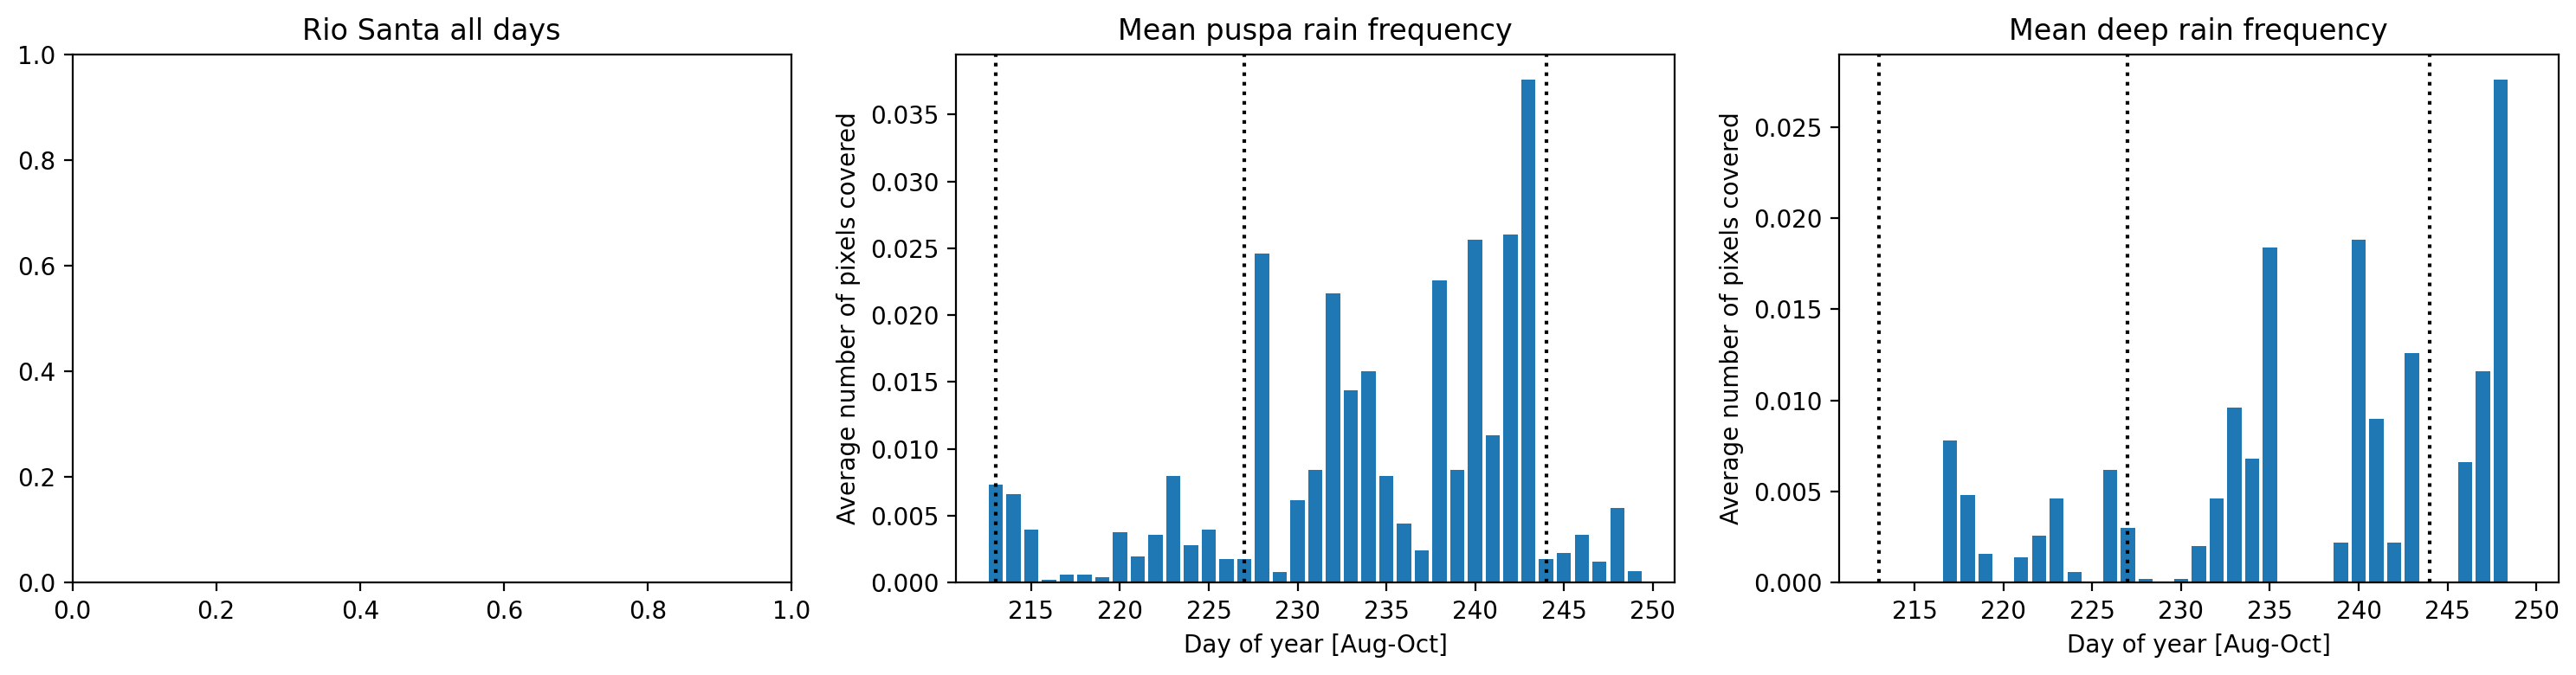

In [94]:
f = plt.figure(figsize=(15,4), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=5))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=5))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=5))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=1) ) | ((wd['time.month']==9) & (wd['time.day']<=5))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
ax = f.add_subplot(1,3,1)

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

plt.title('Rio Santa all days')


ax = f.add_subplot(1,3,2)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70
allpix = wdaug.where((caaug.values>=0)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
# wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
# wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size

wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())


ax.bar(wdin.dayofyear, ws_array)
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(227, linestyle='dotted', color='k')
ax.set_ylabel('Average number of pixels covered')
plt.title('Mean puspa rain frequency')
ax.set_xlabel('Day of year [Aug-Oct]')



ax = f.add_subplot(1,3,3)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -40
blim = -70

# wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size
# wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.dayofyear').count(['latitude', 'time', 'longitude'])/np.unique(wdaug['time.year']).size

wdin = (wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')
wsin = (wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).count(['latitude','longitude'])/wdaug.where((caaug.values>=0)).count(['latitude','longitude'])).groupby('time.dayofyear').mean('time')

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())
ax.axvline(213, linestyle='dotted', color='k')
ax.axvline(244, linestyle='dotted', color='k')
ax.axvline(227, linestyle='dotted', color='k')

ax.bar(wdin.dayofyear, ws_array)
ax.set_ylabel('Average number of pixels covered')
ax.set_xlabel('Day of year [Aug-Oct]')

plt.title('Mean deep rain frequency')


plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/timeseries_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-30_3x.jpg')

AttributeError: 'DataArray' object has no attribute 'year'

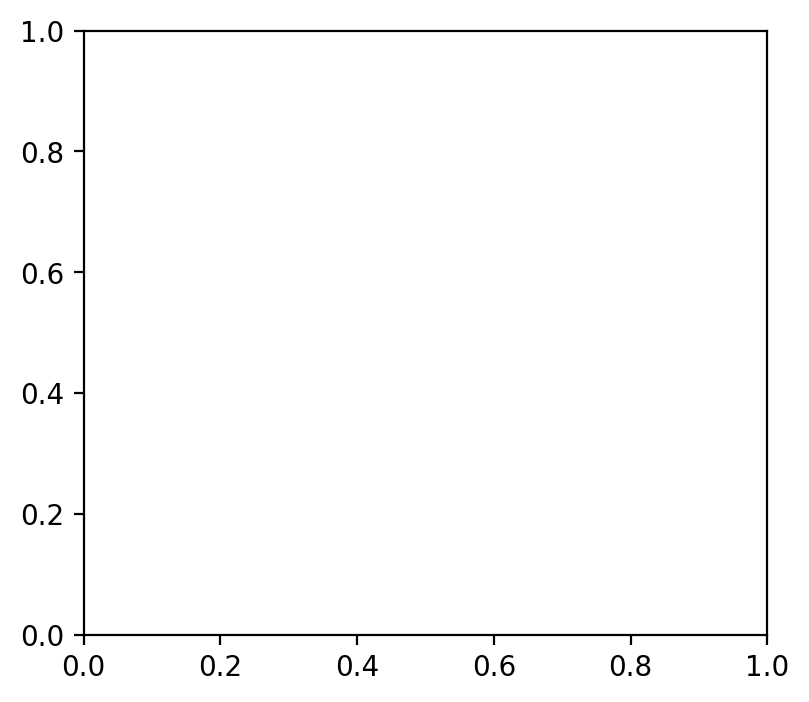

In [86]:
f = plt.figure(figsize=(15,4), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
graug = grid200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=2020)).where(topo_on_g<4500).salem.roi(shape=sdf)
ax = f.add_subplot(1,3,1)

allpix = wdaug.where((caaug.values==0)).groupby('time.year').count(['latitude', 'time', 'longitude'])

ws_array = np.array(allpix.values.flatten())
ws_array = ws_array[np.isfinite(ws_array)]
ax.bar(wdin.year, ws_array-np.mean(ws_array))

color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

plt.title('Rio Santa dry day pixels')


ax = f.add_subplot(1,3,2)

alim = -15 #puspa
blim = -30

dlim = 1

# alim = -30
# blim = -70

wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude'])
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude'])
ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())


ax.bar(wdin.year, ws_array)

ax.set_ylabel('Average number of pixels covered')
plt.title('Mean puspa rain frequency')
ax.set_xlabel('Year [midAug-midSep]')



ax = f.add_subplot(1,3,3)

# alim = -15 #puspa
# blim = -30

dlim = 1

alim = -30
blim = -80

wdin = wdaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude'])
wsin = wsaug.where((graug.values<=alim) & (graug.values>=blim)  & (caaug.values>=dlim)).groupby('time.year').count(['latitude', 'time', 'longitude'])

ws_array = np.array(wsin.values.flatten())
wd_array = np.array(wdin.values.flatten())

ax.bar(wdin.year, ws_array)
ax.set_ylabel('Average number of pixels covered')
ax.set_xlabel('Year [midAug-midSep]')

plt.title('Mean deep rain frequency')


plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/timeseries_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-30_3x.jpg')

cloudy cases 7570
all cases 159936
nb years 34


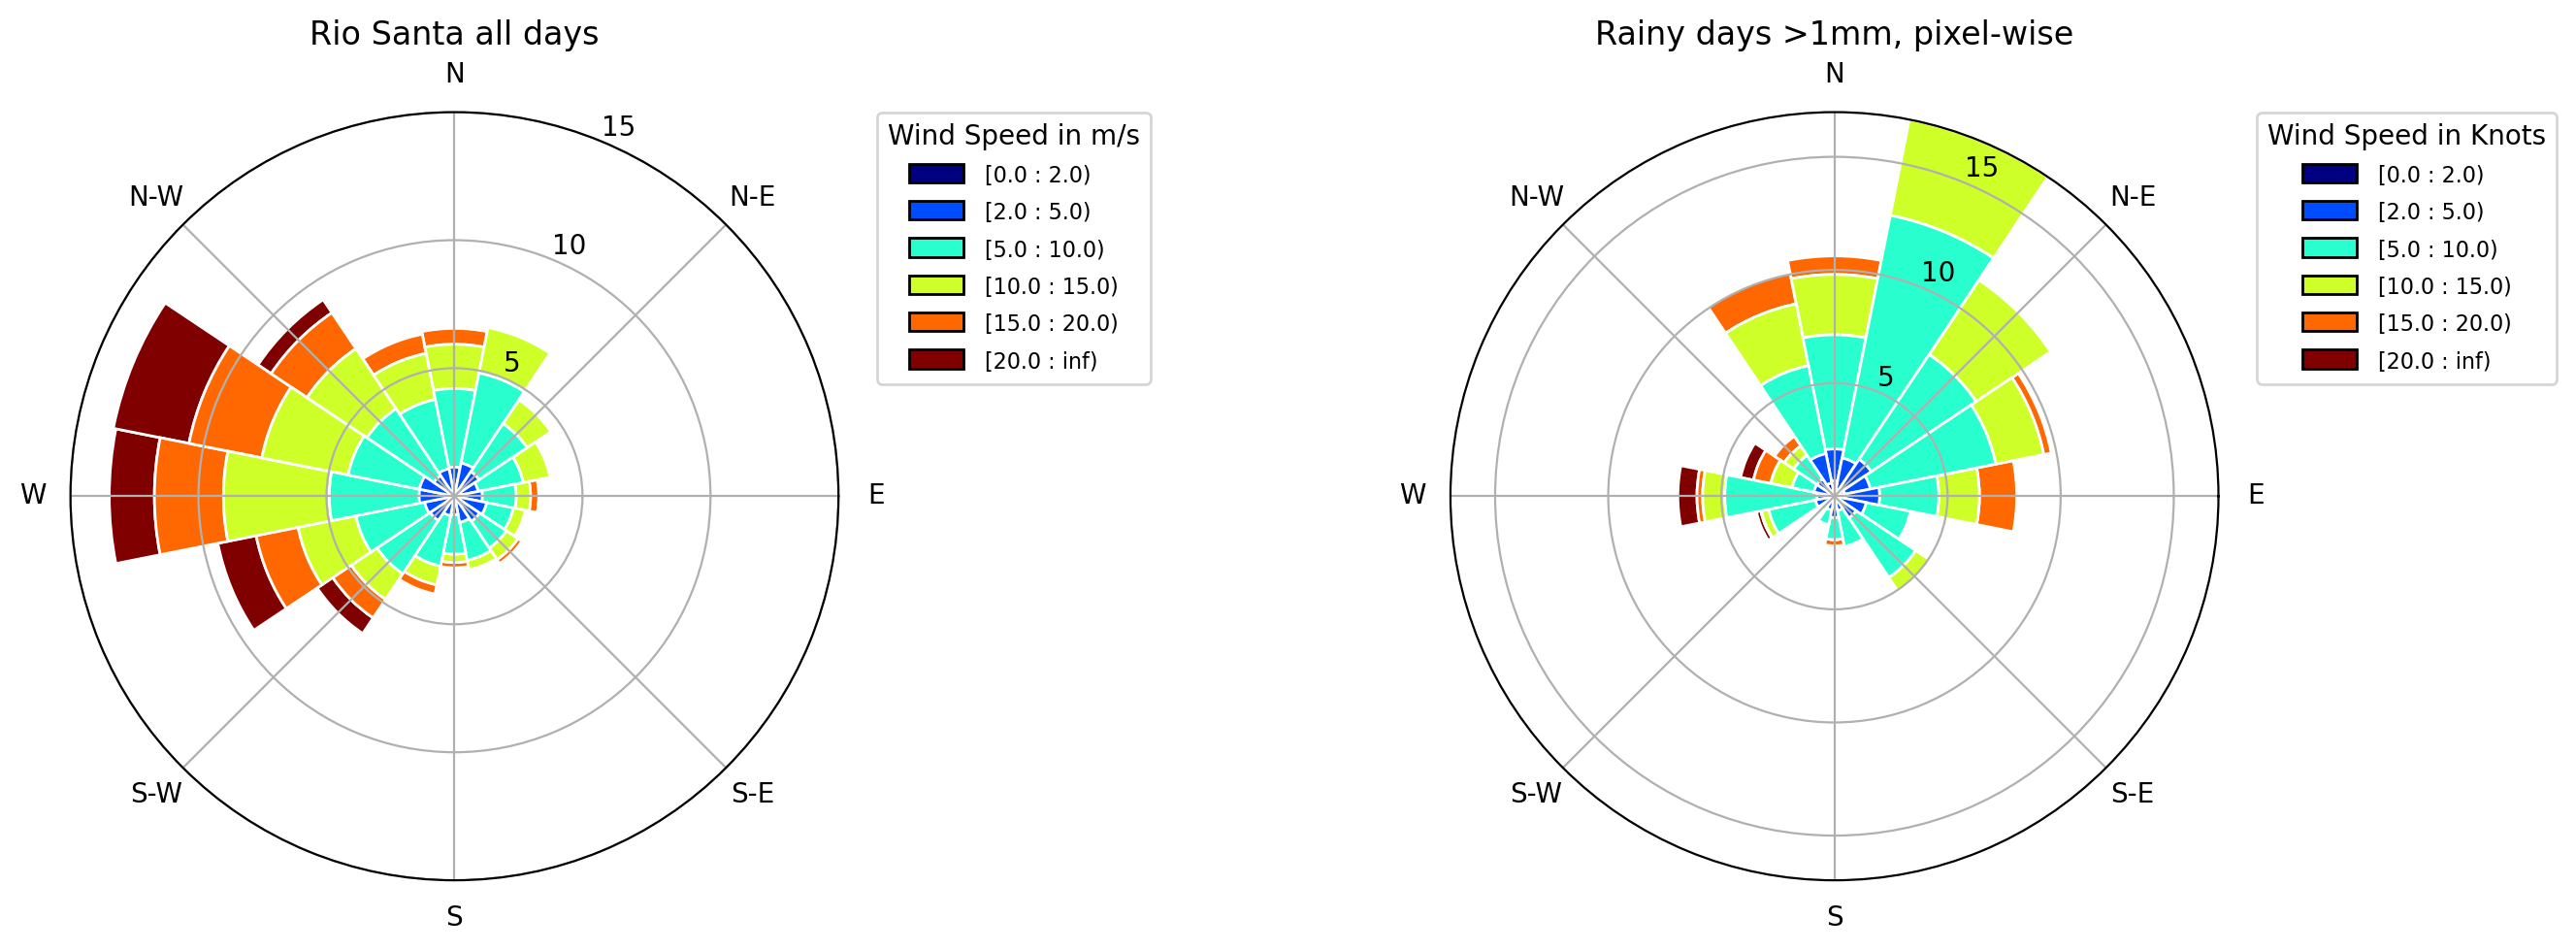

In [72]:
f = plt.figure(figsize=(15,5), dpi=200)

wdaug = wd.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']>=1980)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']>=1980)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = grid200.sel(time=(((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']>=1980)).where(topo_on_g<4500).salem.roi(shape=sdf)
ax = f.add_subplot(1,2,1, projection='windrose')

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))

ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
plt.title('Rio Santa all days')


ax = f.add_subplot(1,2,2, projection='windrose')

# alim = -15 #puspa
# blim = -25

alim = -30
blim = -90

wdin = wdaug.values[(caaug.values<=alim) & (caaug.values>=blim)]
wsin = wsaug.values[(caaug.values<=alim) & (caaug.values>=blim)]

print('cloudy cases', wdin.size)
print('all cases', ws_array.size)
print('nb years', np.unique(wdaug['time.year']).size)

ws_array = np.array(wsin.flatten())
wd_array = np.array(wdin.flatten())

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(5, 20, step=5))
ax.set_yticklabels(np.arange(5, 20, step=5))
plt.title('Rainy days >1mm, pixel-wise')


ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
# if mon == 1:
#     plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_GRIDSAT_Aug-Sep_RD1mm_topoLT4500_GT-20.jpg')

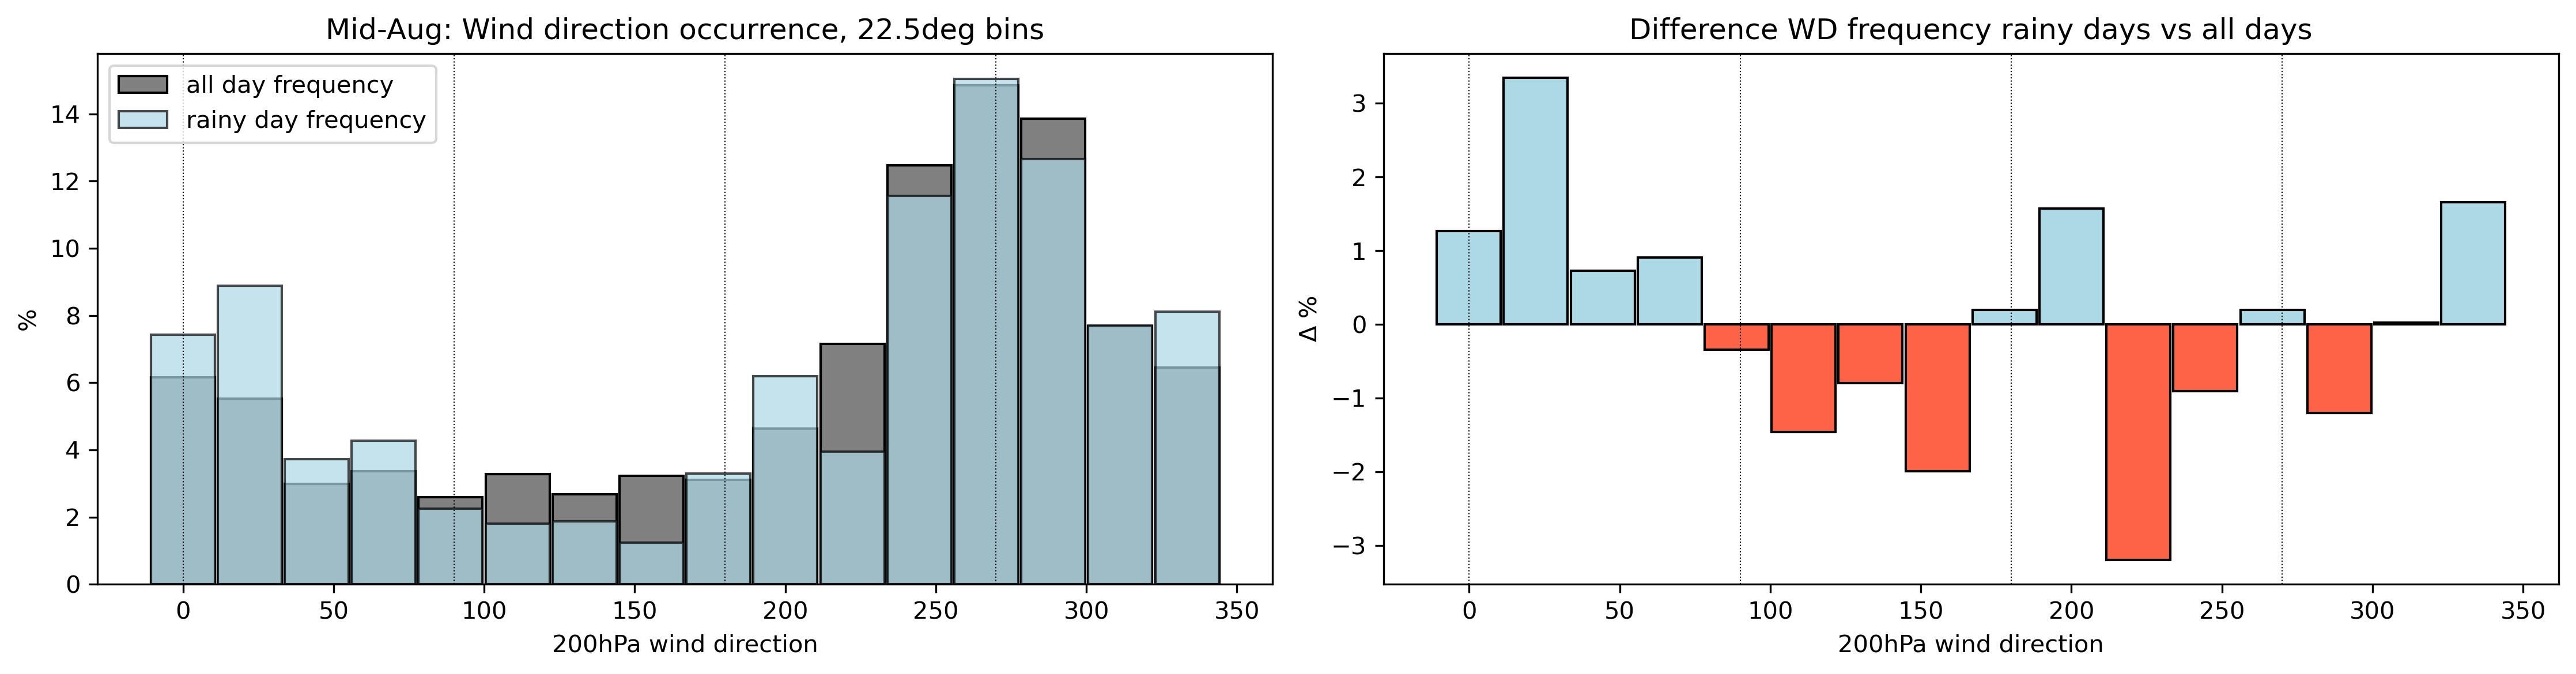

In [213]:
mon = 8

f = plt.figure(figsize = (15,4), dpi=300)

wdaug = wd.sel(time= ((wd['time.month']==8) & (wd['time.day']>=15)) | ((wd['time.month']==9) & (wd['time.day']<=5))).where(topo_on_g<4500).salem.roi(shape=sdf)+180-11.25
wsaug = ws.sel(time= ((wd['time.month']==8) & (wd['time.day']>=15)) | ((wd['time.month']==9) & (wd['time.day']<=5))).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = grid200.sel(time= ((wd['time.month']==8) & (wd['time.day']>=15)) | ((wd['time.month']==9) & (wd['time.day']<=5))).where(topo_on_g<4500).salem.roi(shape=sdf)

mean, bins, binnb = stats.binned_statistic(wdaug.values.flatten(), ((caaug.values.flatten()<=alim) & (caaug.values.flatten()>=blim)).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2

meanz, binsz, binnbz = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()<=0).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2


ax = f.add_subplot(1,2,1)
plt.bar(mbins, meanz/np.sum(meanz)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='all day frequency', color='grey')
plt.bar(mbins, mean/np.sum(mean)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='rainy day frequency', color='lightblue', alpha=0.7)
plt.title('Mid-Aug: Wind direction occurrence, 22.5deg bins')
ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

ax.set_ylabel('%')
ax.set_xlabel('200hPa wind direction')
plt.legend()

ax = f.add_subplot(1,2,2)
cbars = ['lightblue']*16
dat = ((mean/np.sum(mean) - meanz/np.sum(meanz)))*100
bposi = np.where(dat < 0)
cbars = np.array(cbars)
cbars[bposi] = 'tomato'

plt.bar(mbins,dat , width=(bins[1::]-bins[0:-1]-1), edgecolor='k', color=cbars)
#plt.bar(mbins, mean/np.sum(mean), width=(bins[1::]-bins[0:-1]), edgecolor='k')
plt.title('Difference WD frequency rainy days vs all days')
ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

ax.set_ylabel(r'$\Delta$ %')
ax.set_xlabel('200hPa wind direction')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/histo_GRIDSAT_Aug-Sep_RD1mm_topo_topoLT4500_22.5deg_GT-20.jpg')

rainy cases 986
all cases 159936
nb years 34


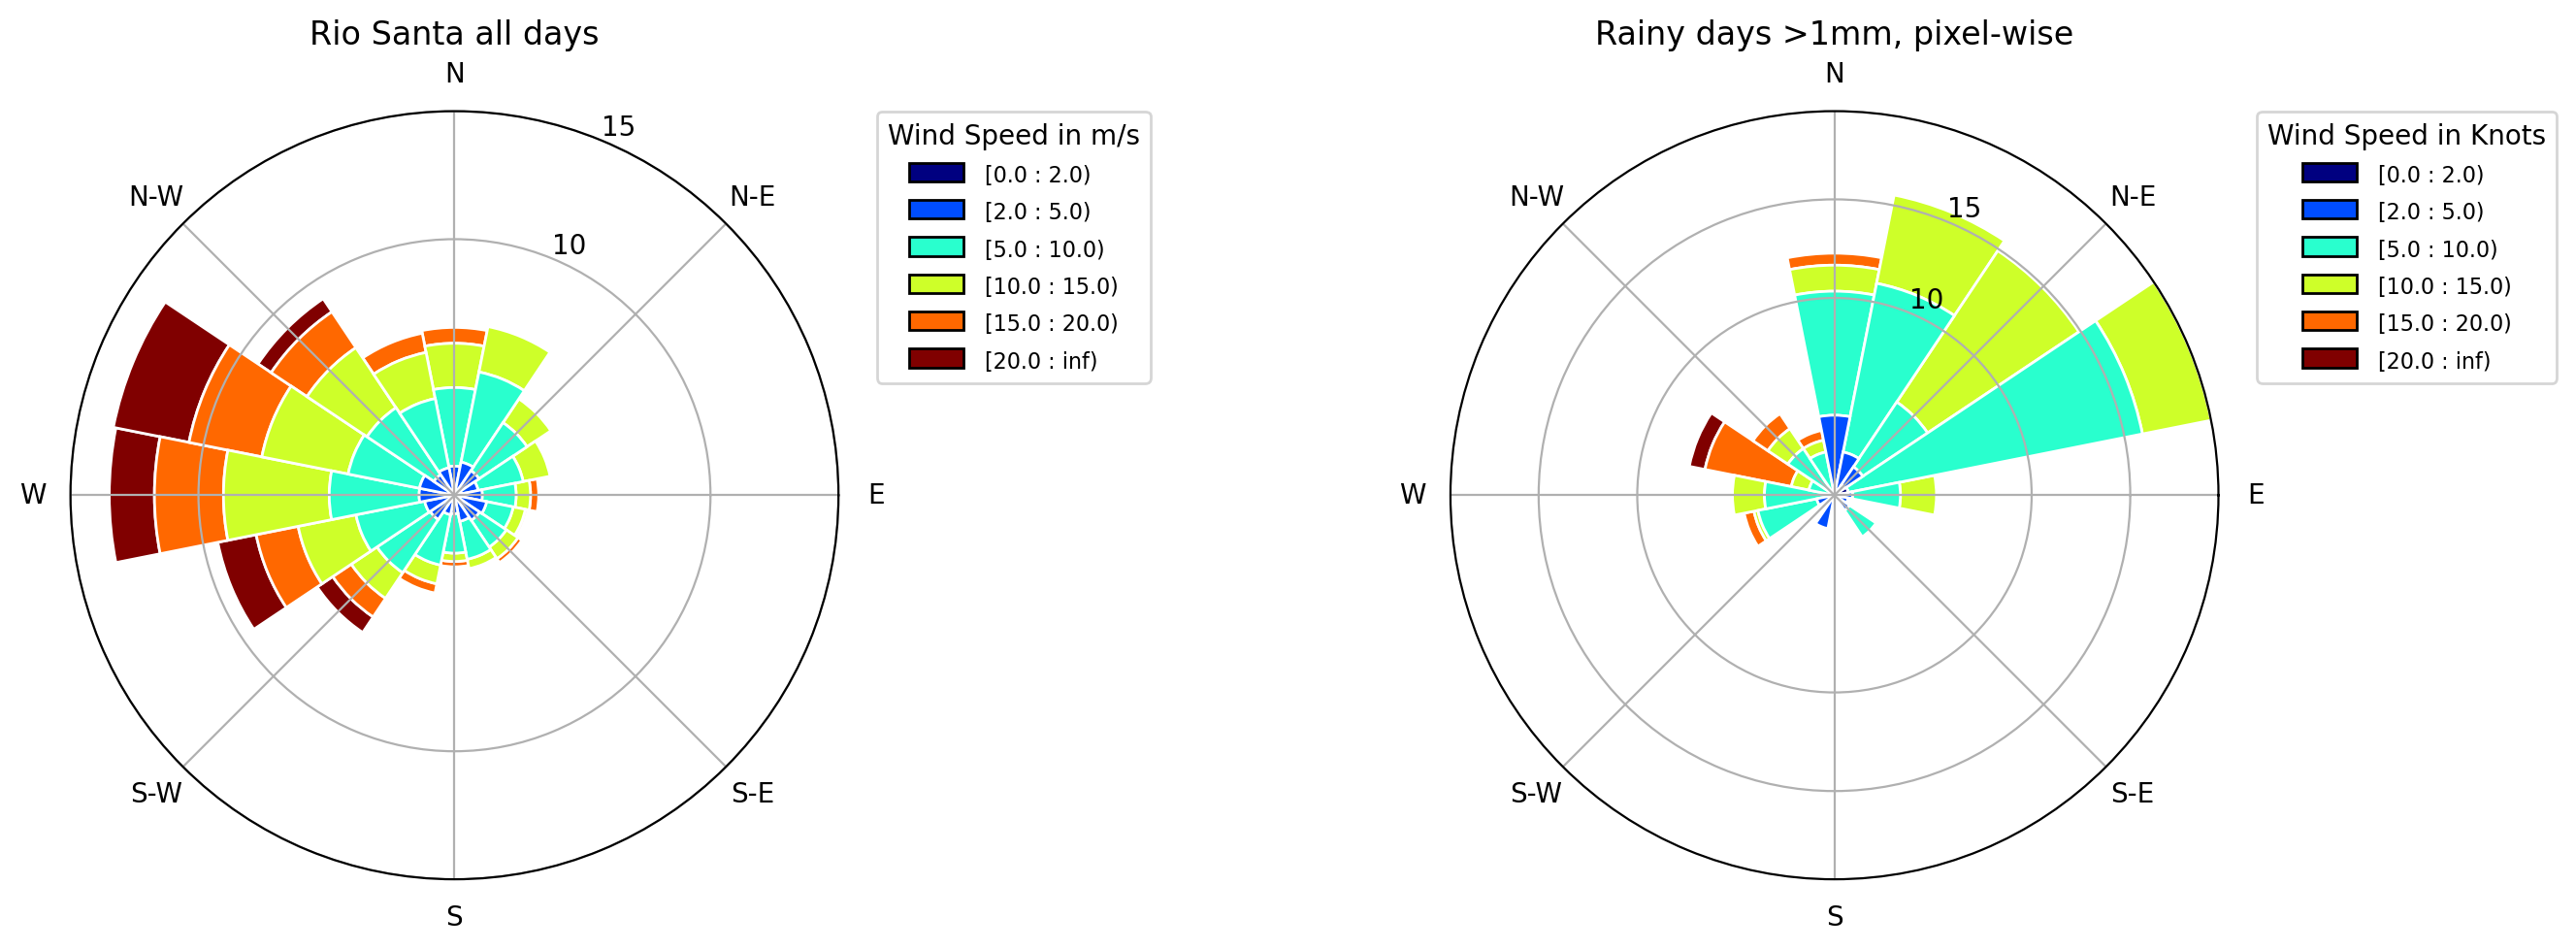

In [217]:
f = plt.figure(figsize=(15,5), dpi=200)
y1=2020

wdaug = wd.sel(time=  (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=y1)).where(topo_on_g<4500).salem.roi(shape=sdf)+180
wsaug = ws.sel(time=  (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=y1)).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time= (((wd['time.month']==8) & (wd['time.day']>=15) ) | ((wd['time.month']==9) & (wd['time.day']<=15))) & (wd['time.year']<=y1)).where(topo_on_g<4500).salem.roi(shape=sdf)
ax = f.add_subplot(1,2,1, projection='windrose')

ws_array = np.array(wsaug.values.flatten())
wd_array = np.array(wdaug.values.flatten())

ws_array = ws_array[np.isfinite(ws_array)]
wd_array = wd_array[np.isfinite(wd_array)]

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(10, 20, step=5))
ax.set_yticklabels(np.arange(10, 20, step=5))

ax.set_legend(title = 'Wind Speed in m/s', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
plt.title('Rio Santa all days')


ax = f.add_subplot(1,2,2, projection='windrose')

# alim = 0.1 #puspa
# blim = 2

alim = 10
blim = 100

wdin = wdaug.values[(caaug.values>=alim) & (caaug.values<=blim)]
wsin = wsaug.values[(caaug.values>=alim) & (caaug.values<=blim)]

print('rainy cases', wdin.size)
print('all cases', ws_array.size)
print('nb years', np.unique(wdaug['time.year']).size)

ws_array = np.array(wsin.flatten())
wd_array = np.array(wdin.flatten())

ax = WindroseAxes.from_ax(ax)
ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
ax.set_yticks(np.arange(10, 20, step=5))
ax.set_yticklabels(np.arange(10, 20, step=5))
plt.title('Rainy days >1mm, pixel-wise')


color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
if mon == 1:
    plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_Aug-Sep_RD1mm_topoLT4500_GT1mm.jpg')

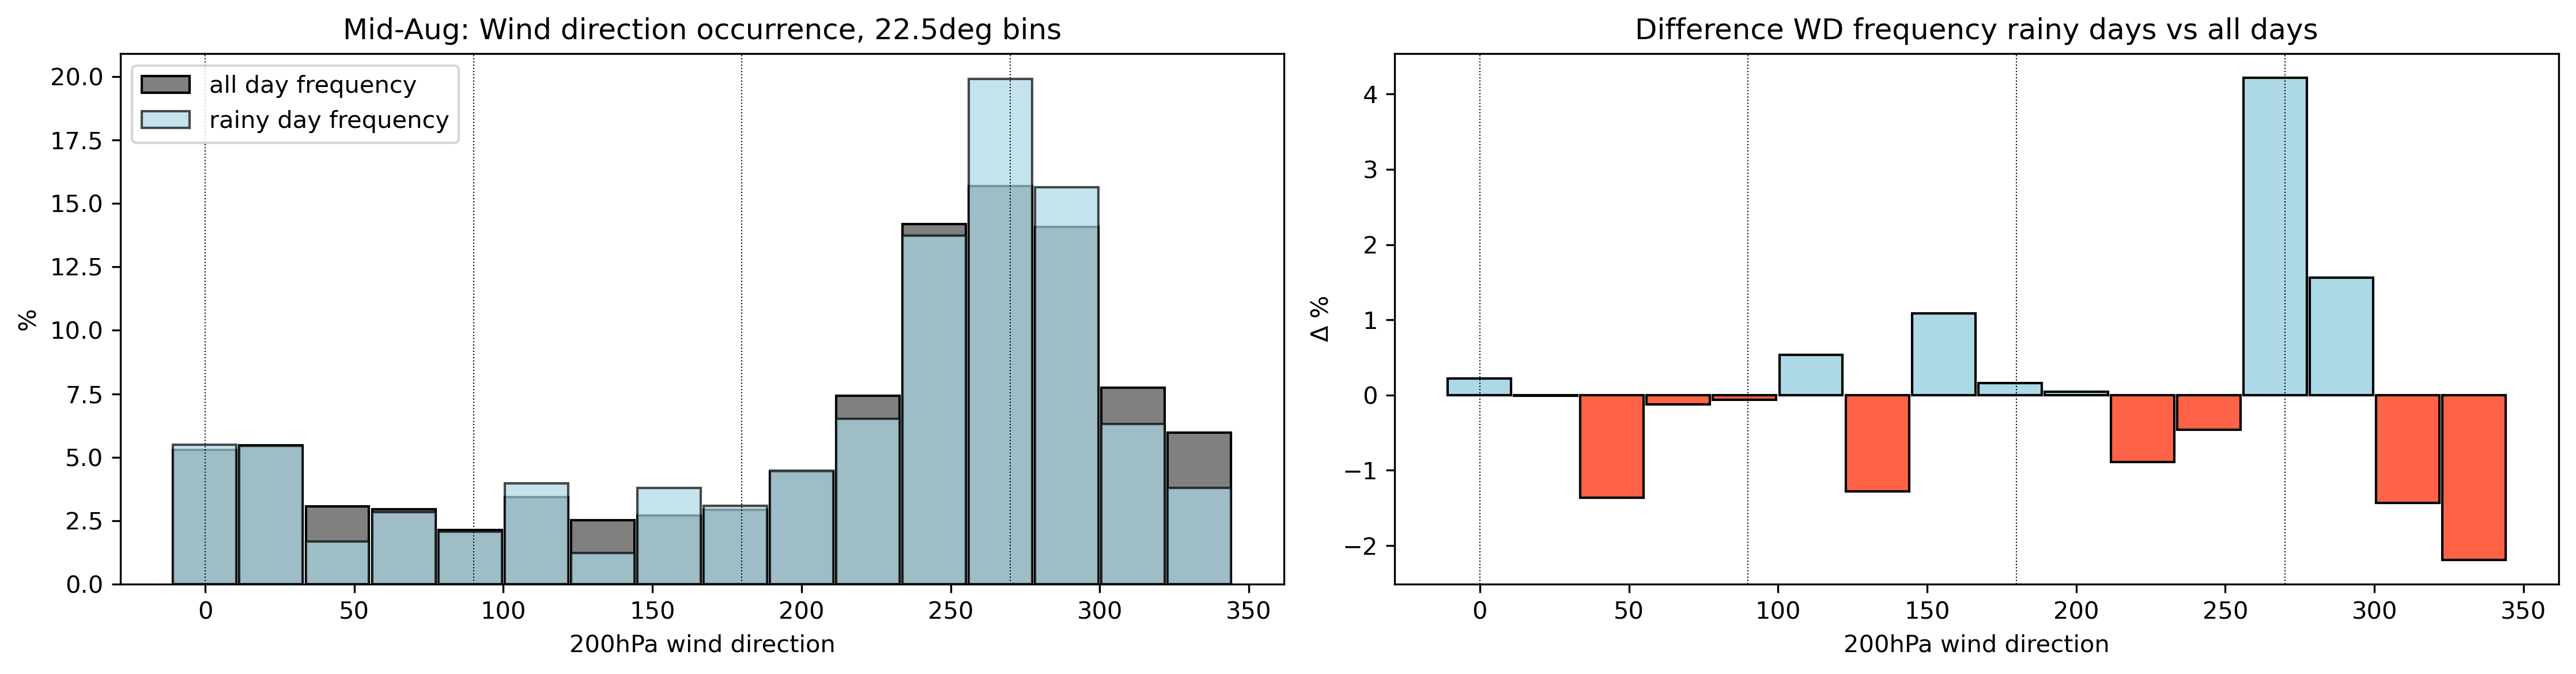

In [256]:
mon = 8

f = plt.figure(figsize = (15,4), dpi=300)

wdaug = wd.sel(time= ((wd['time.month']==8) & (wd['time.day']>=10)) | ((wd['time.month']==9) & (wd['time.day']<=1))).where(topo_on_g<4500).salem.roi(shape=sdf)+180-11.25
wsaug = ws.sel(time= ((wd['time.month']==8) & (wd['time.day']>=10)) | ((wd['time.month']==9) & (wd['time.day']<=1))).where(topo_on_g<4500).salem.roi(shape=sdf)
caaug = cau200.sel(time= ((wd['time.month']==8) & (wd['time.day']>=10)) | ((wd['time.month']==9) & (wd['time.day']<=1))).where(topo_on_g<4500).salem.roi(shape=sdf)

mean, bins, binnb = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=2).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2

meanz, binsz, binnbz = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=0).astype(int), bins=np.arange(-11.25,361,22.24), statistic=np.nansum)
mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2


ax = f.add_subplot(1,2,1)
plt.bar(mbins, meanz/np.sum(meanz)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='all day frequency', color='grey')
plt.bar(mbins, mean/np.sum(mean)*100, width=(bins[1::]-bins[0:-1]-1), edgecolor='k', label='rainy day frequency', color='lightblue', alpha=0.7)
plt.title('Mid-Aug: Wind direction occurrence, 22.5deg bins')
ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

ax.set_ylabel('%')
ax.set_xlabel('200hPa wind direction')
plt.legend()

ax = f.add_subplot(1,2,2)
cbars = ['lightblue']*16
dat = ((mean/np.sum(mean) - meanz/np.sum(meanz)))*100
bposi = np.where(dat < 0)
cbars = np.array(cbars)
cbars[bposi] = 'tomato'

plt.bar(mbins,dat , width=(bins[1::]-bins[0:-1]-1), edgecolor='k', color=cbars)
#plt.bar(mbins, mean/np.sum(mean), width=(bins[1::]-bins[0:-1]), edgecolor='k')
plt.title('Difference WD frequency rainy days vs all days')
ax.axvline(90, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(180, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(270, color='k', linewidth=0.5, linestyle='dotted')
ax.axvline(0, color='k', linewidth=0.5, linestyle='dotted')

ax.set_ylabel(r'$\Delta$ %')
ax.set_xlabel('200hPa wind direction')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/histo_Aug-Sep_RD1mm_topo_topoLT4500_22.5deg_augOnly.jpg')

Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12


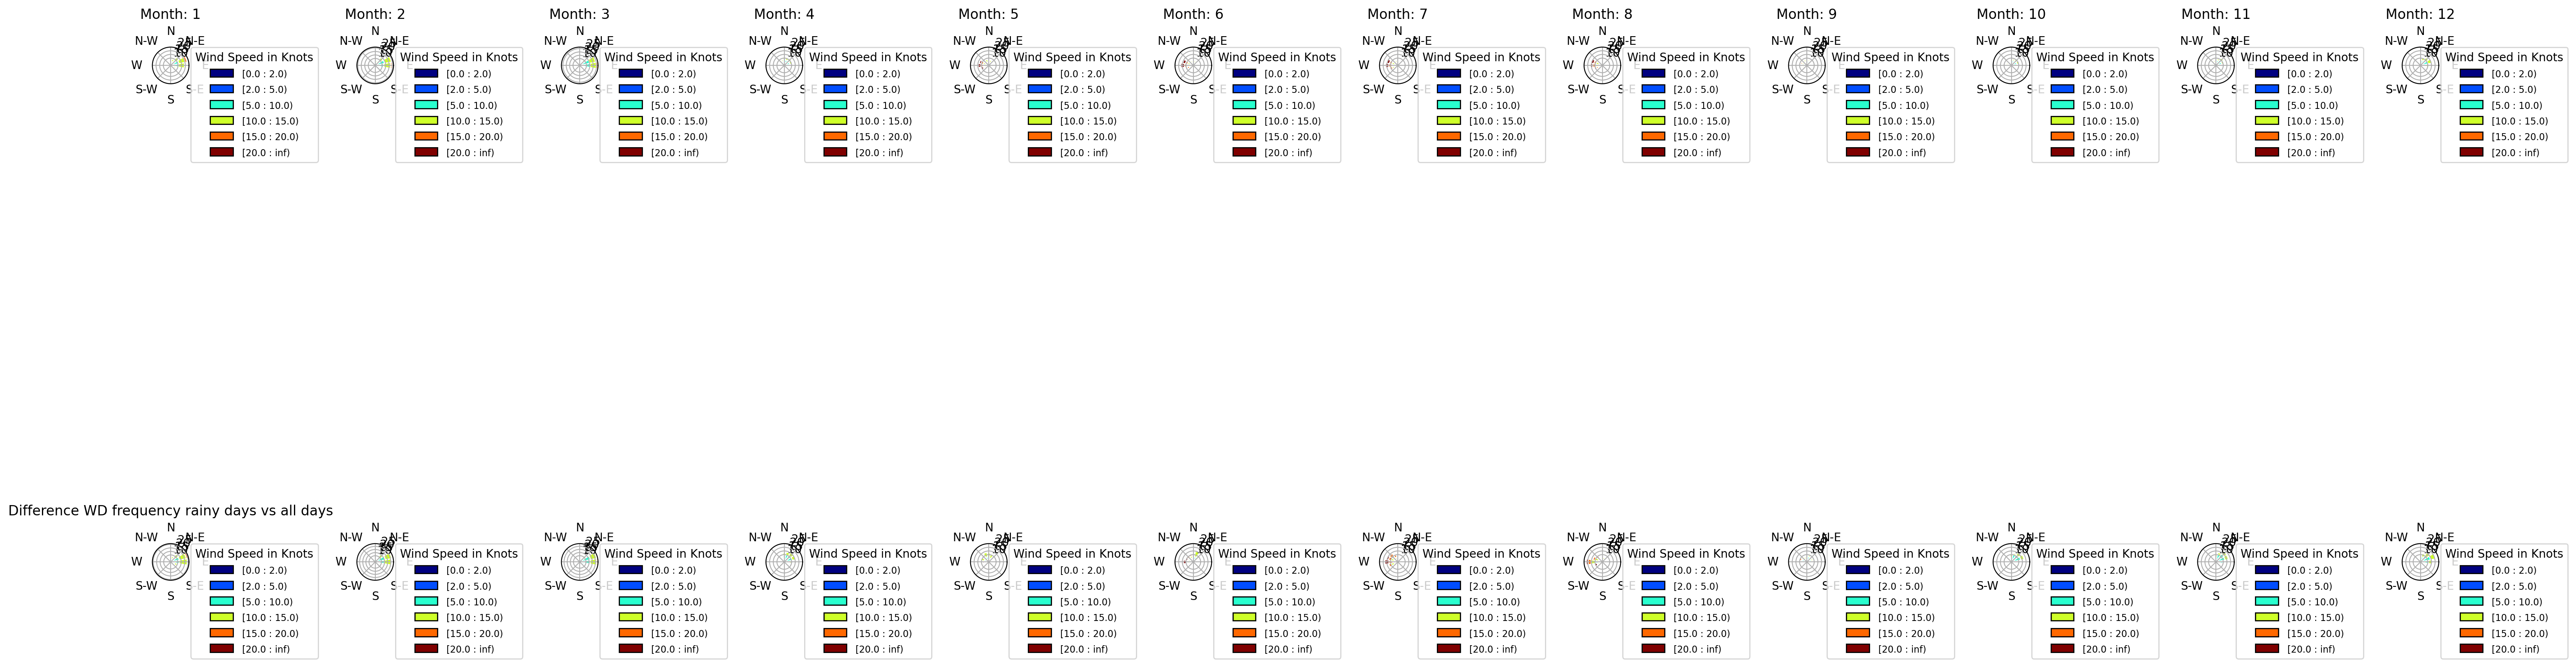

In [192]:
f = plt.figure(figsize=(40,10), dpi=200)
for mon in range(1,13):
    print('Doing', mon)
    wdaug = wd.sel(time= (wd['time.month']==mon)).salem.roi(shape=sdf)+180
    wsaug = ws.sel(time= (wd['time.month']==mon)).salem.roi(shape=sdf)
    caaug = cau200.sel(time= (cau200['time.month']==mon)).salem.roi(shape=sdf)
    ax = f.add_subplot(2,12,mon, projection='windrose')
    
    ws_array = np.array(wsaug.values.flatten())
    wd_array = np.array(wdaug.values.flatten())
    
    ws_array = ws_array[np.isfinite(ws_array)]
    wd_array = wd_array[np.isfinite(wd_array)]

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
    ax.set_yticks(np.arange(10, 30, step=5))
    ax.set_yticklabels(np.arange(10, 30, step=5))

    ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    plt.title('Month: '+str(mon))

              
    ax = f.add_subplot(2,12,mon+12, projection='windrose')
                    
    wdin = wdaug.values[caaug.values>1]
    wsin = wsaug.values[caaug.values>1]

    ws_array = np.array(wsin.flatten())
    wd_array = np.array(wdin.flatten())

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array, ws_array, normed=True, opening=1.0, edgecolor='white', bins=[0,2,5,10,15,20])
    ax.set_yticks(np.arange(10, 30, step=5))
    ax.set_yticklabels(np.arange(10, 30, step=5))


    color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']
    
    ax.set_legend(title = 'Wind Speed in Knots', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
    if mon == 1:
        plt.title('Difference WD frequency rainy days vs all days')

plt.tight_layout()
plt.show()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/windrose_per_month_RD1mm.png')

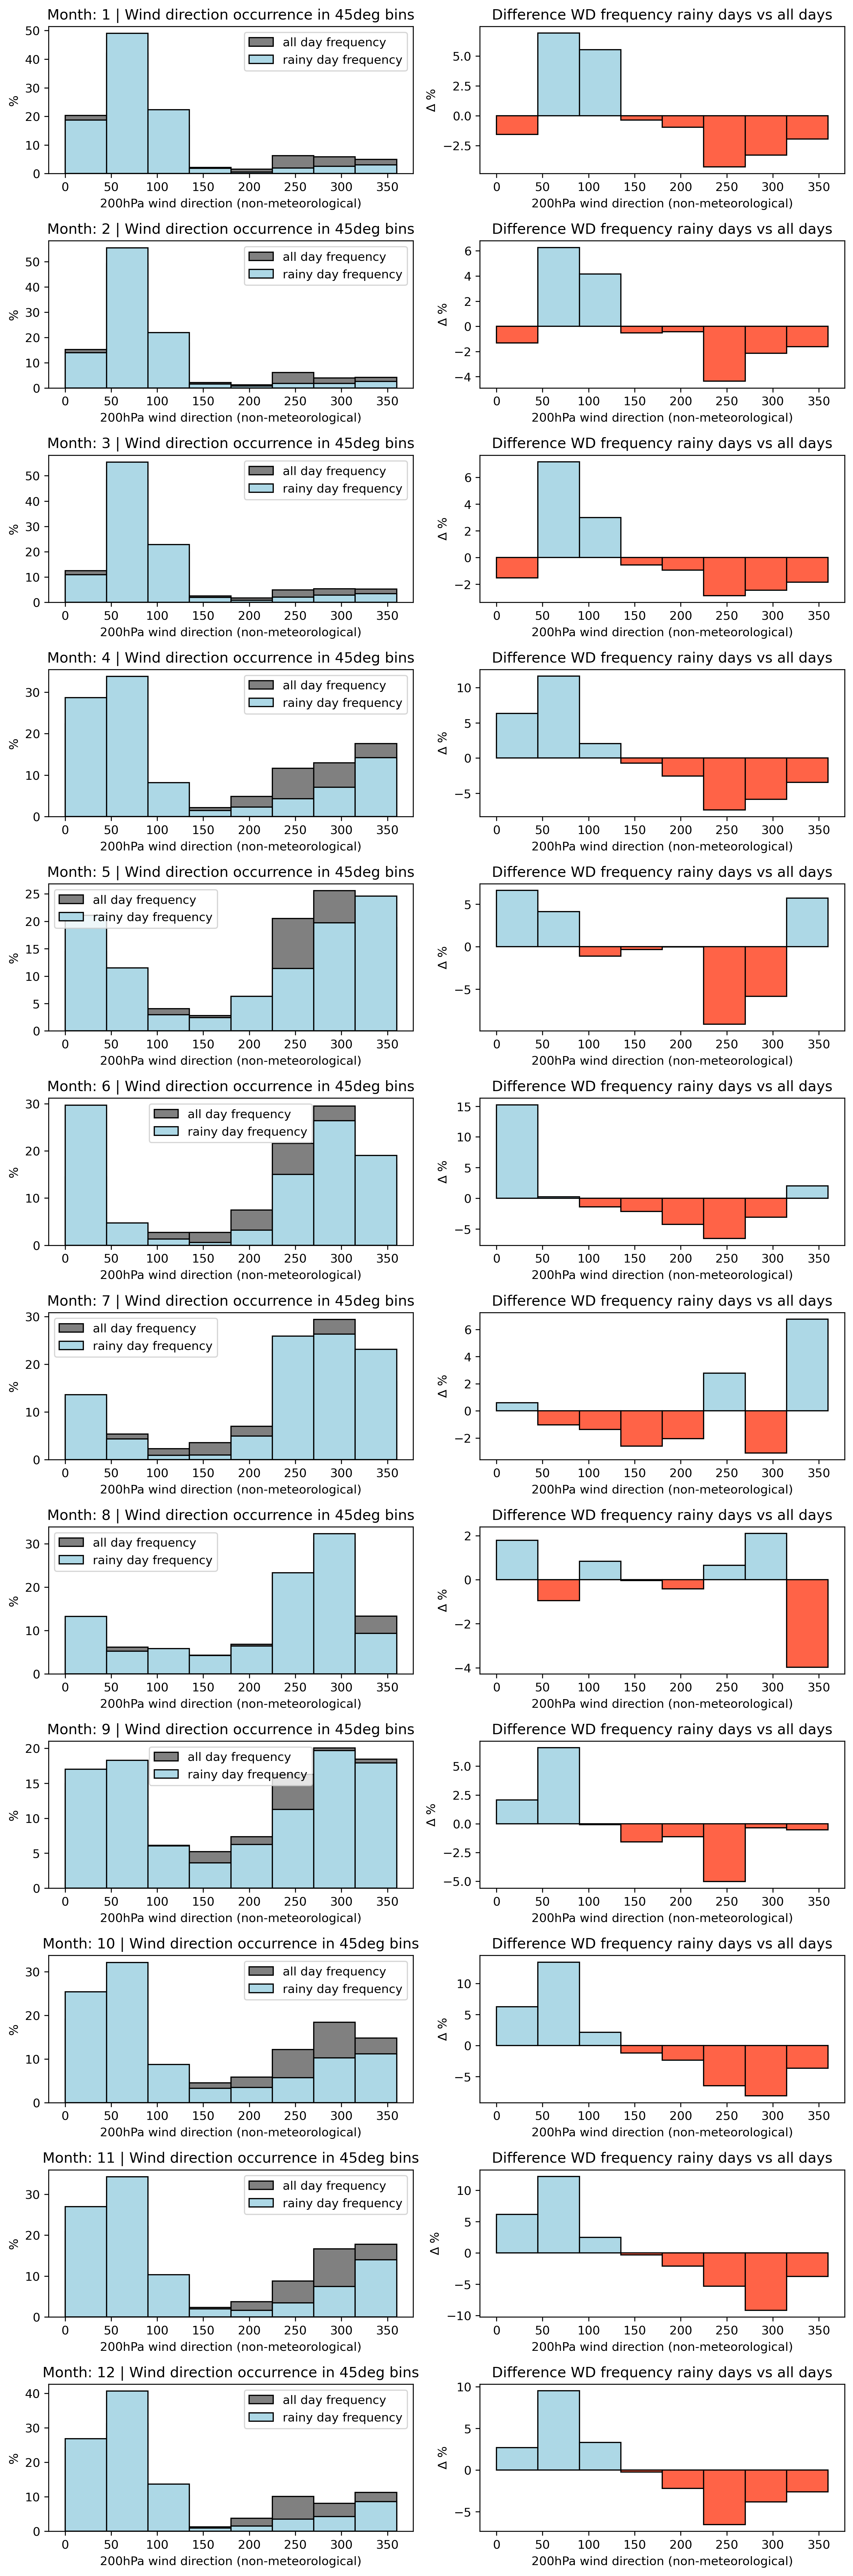

In [185]:
f = plt.figure(figsize=(10,30), dpi=300)


for mon in range(1,13):

    wdaug = wd.sel(time= (wd['time.month']==mon))+180 #.salem.roi(shape=sdf)+180
    caaug = cau200.sel(time= (cau200['time.month']==mon))#.salem.roi(shape=sdf)

    mean, bins, binnb = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=1).astype(int), bins=np.arange(0,361,45), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2

    meanz, binsz, binnbz = stats.binned_statistic(wdaug.values.flatten(), (caaug.values.flatten()>=0).astype(int), bins=np.arange(0,361,45), statistic=np.nansum)
    mbins = bins[0:-1] + (bins[1::]-bins[0:-1])/2
    
    
    ax = f.add_subplot(12,2,mon+(mon-1))
    plt.bar(mbins, meanz/np.sum(meanz)*100, width=(bins[1::]-bins[0:-1]), edgecolor='k', label='all day frequency', color='grey')
    plt.bar(mbins, mean/np.sum(mean)*100, width=(bins[1::]-bins[0:-1]), edgecolor='k', label='rainy day frequency', color='lightblue')
    plt.title('Month: '+str(mon)+' | Wind direction occurrence in 45deg bins')

    ax.set_ylabel('%')
    ax.set_xlabel('200hPa wind direction (non-meteorological)')
    plt.legend()
    ax = f.add_subplot(12,2,mon*2)
    cbars = ['lightblue']*8
    dat = ((mean/np.sum(mean) - meanz/np.sum(meanz)))*100
    bposi = np.where(dat < 0)
    cbars = np.array(cbars)
    cbars[bposi] = 'tomato'

    plt.bar(mbins,dat , width=(bins[1::]-bins[0:-1]), edgecolor='k', color=cbars)
    #plt.bar(mbins, mean/np.sum(mean), width=(bins[1::]-bins[0:-1]), edgecolor='k')
    plt.title('Difference WD frequency rainy days vs all days')

    ax.set_ylabel(r'$\Delta$ %')
    ax.set_xlabel('200hPa wind direction (non-meteorological)')
plt.tight_layout()

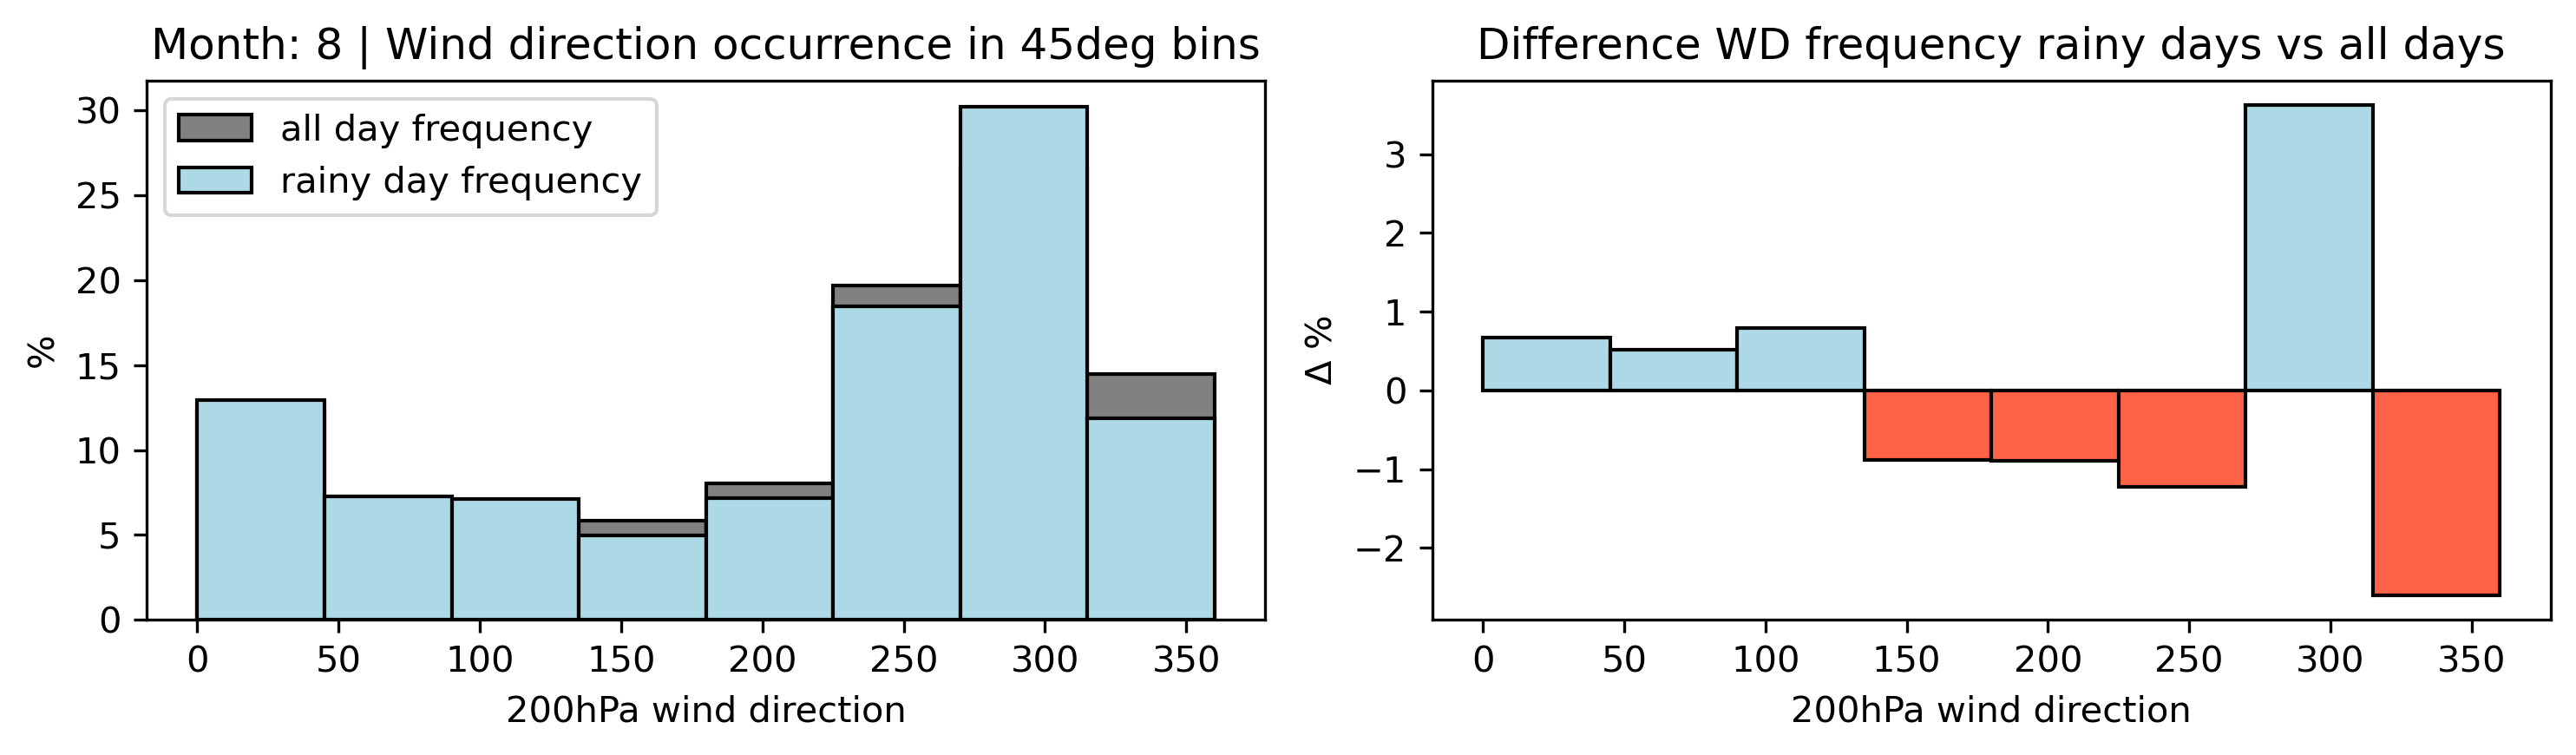

In [271]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lat=slice(isbuffer[2],isbuffer[3]), lon=slice(isbuffer[0], isbuffer[1]))
topo_on_grid = rio_santa.salem.lookup_transform(topo)

In [272]:
rs = rio_santa.sel(lon=slice(-78.5,-76.5), lat=slice(-10.5,-8.5))#.mean('time').plot() 

In [284]:
rs4500 = rs['tir'].where(  (topo_on_grid<5000) & (rs['tir']<-1500)).sel(time= ((rs['time.month']==8) & (rs['time.day']>=10)) | ((rs['time.month']==9) & (rs['time.day']<=10)))#.groupby('time.year').quantile(0.25, dim=['time','lat', 'lon'])

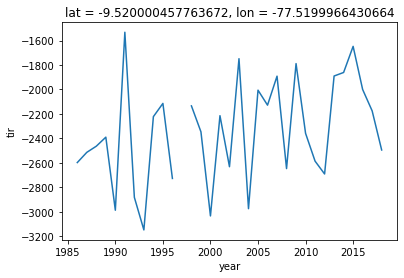

In [285]:
rs4500.groupby('time.year').mean(['time']).sel(lat=-9.5, lon=-77.5, method='nearest').plot()

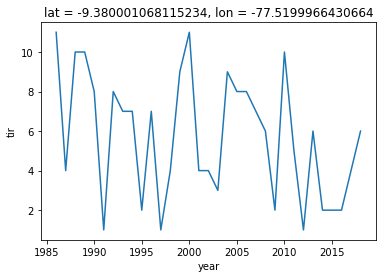

In [286]:
rs4500.groupby('time.year').count(['time']).sel(lat=-9.4, lon=-77.5, method='nearest').plot()

In [298]:
from utils import u_statistics as us
def calc_trend(data, hour=None, method=None, sig=False, wilks=False, cmethod='mean'):

    y1 = 1986
    y2 = 2019

    if method is None:
        'Please provide trend calc method: polyfit or mk (mann kendall)'

#     if len(data.time)==0:
#         print('Data does not seem to have picked month or hour. Please check input data')
    
    if cmethod == 'mean':
         mean_years = data.groupby('time.year').mean('time')
    if cmethod == 'count':
        mean_years = data.groupby('time.year').count('time') #frequency per year # / data['time'].groupby('time.year').count('time')[0]  # frequency per day

    
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['lat', 'lon'])


    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.01,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='linregress':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0
            
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_polyfit,nb_valid=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = 0

    ddtrend = dtrend['slope']

    if wilks and sig:
        try:
            pthresh = us.fdr_threshold(dtrend['pval'].values[np.isfinite(dtrend['pval'].values)], alpha=alpha)
            ddtrend.values[(dtrend['pval'].values > pthresh) | np.isnan(dtrend['pval'].values)] = np.nan
        except ValueError:
            ddtrend.values = ddtrend.values * np.nan
            pthresh = np.nan
        print('p value threshold', pthresh)
#     ipdb.set_trace()
#     unstack back to lat lon coordinates
    
    ddout = dtrend
    
    return ddout, mean_years

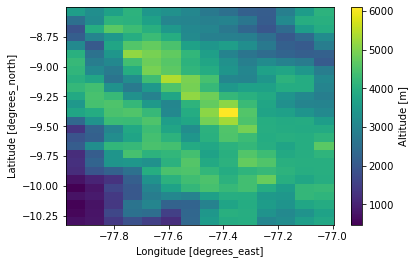

In [299]:
topo_on_grid.plot()

In [302]:
tirtrendf, tirmeanf = calc_trend(rs4500, method='mk', sig=False, wilks=False, cmethod='count')
tirm_meanf = tirmeanf.mean('year')

Entering trend calc


/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ck/miniconda3/lib/python3.7/

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

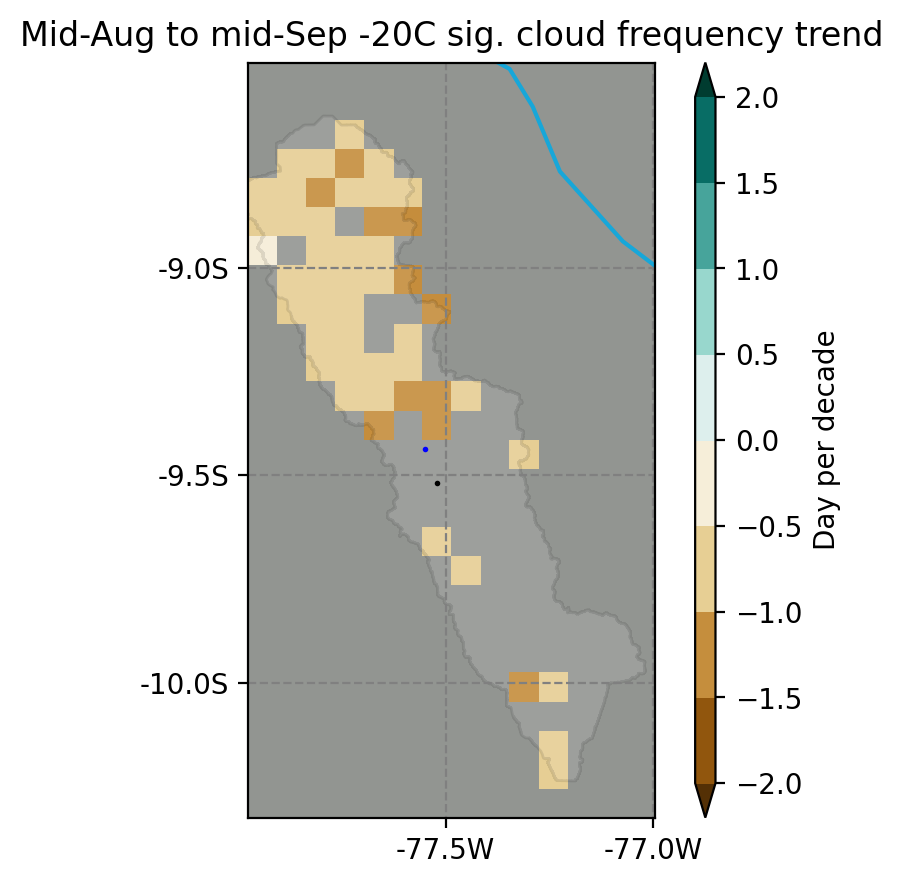

In [303]:
m=1
smap = tirtrend.salem.get_map()
f = plt.figure(figsize=(9,5), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(cmap='BrBG', extend='both') #levels=np.linspace(-20, 20, 8)
smap.set_shapefile(rivers=True)
smap.set_shapefile(lakes=True, facecolor='blue', edgecolor='blue')

x, y = smap.grid.transform(-77.52, -9.52)
xx, yy = smap.grid.transform(-77.55, -9.438)

cnt = 0


ax = f.add_subplot(111)
ax.set_facecolor('xkcd:grey')

plt.plot(x, y, 'ko', markersize=1)
plt.plot(xx, yy, 'bo', markersize=1)

smap.set_plot_params(cmap='BrBG', extend='both',levels=np.arange(-2, 2.1, 0.5)) #levels=np.linspace(-20, 20, 8)
smap.set_data((tirtrendf['slope'].where(tirtrendf['pval']<0.05))*10) #np.round(pl*10,2)/mmean*100)
smap.visualize(ax=ax,addcbar=True, title='Mid-Aug to mid-Sep -20C sig. cloud frequency trend', cbar_title='Day per decade')

    
plt.tight_layout

In [304]:
tirtrend, tirmean = calc_trend(rs4500, method='mk', sig=False, wilks=False, cmethod='mean')
tirm_mean = tirmean.mean('year')

Entering trend calc


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

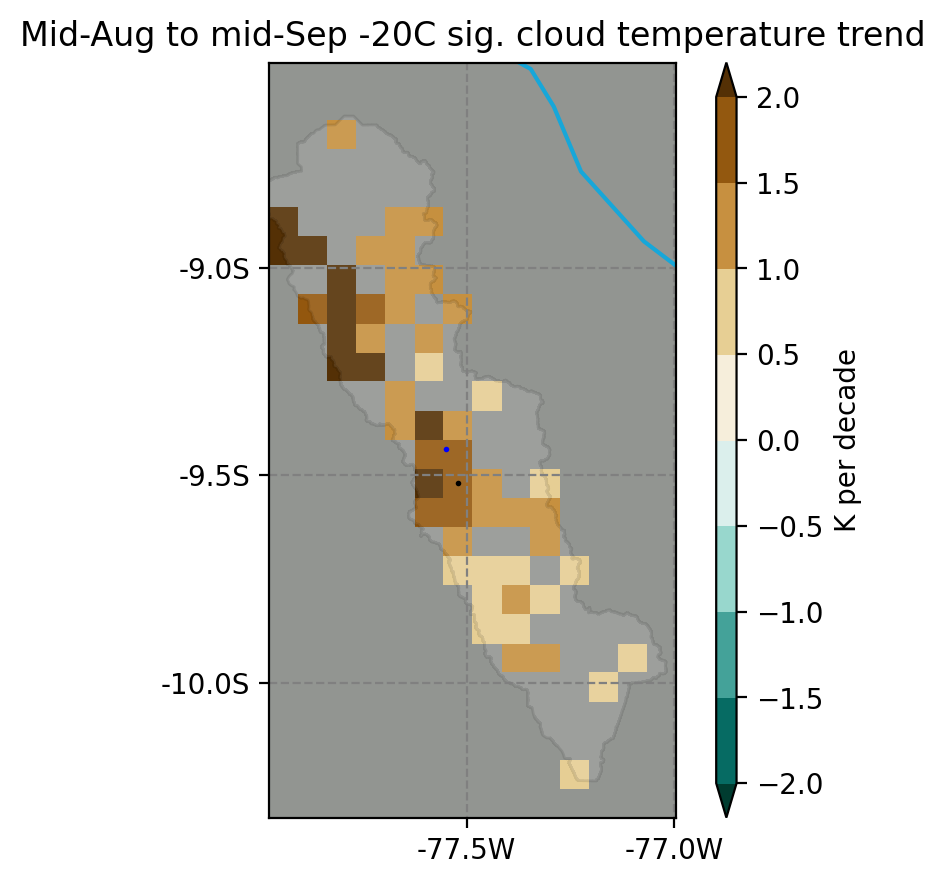

In [305]:
m=1
smap = tirtrend.salem.get_map()
f = plt.figure(figsize=(9,5), dpi=200)

smap.set_shapefile(sdf,facecolor='white', color='k', linewidth=1., alpha=0.1)
smap.set_plot_params(cmap='BrBG', extend='both') #levels=np.linspace(-20, 20, 8)
smap.set_shapefile(rivers=True)
smap.set_shapefile(lakes=True, facecolor='blue', edgecolor='blue')

x, y = smap.grid.transform(-77.52, -9.52)
xx, yy = smap.grid.transform(-77.55, -9.438)

cnt = 0


ax = f.add_subplot(111)
ax.set_facecolor('xkcd:grey')

plt.plot(x, y, 'ko', markersize=1)
plt.plot(xx, yy, 'bo', markersize=1)

smap.set_plot_params(cmap='BrBG_r', extend='both',levels=np.arange(-2, 2.1, 0.5)) #levels=np.linspace(-20, 20, 8)
smap.set_data((tirtrend['slope'].where(tirtrend['pval']<0.05))/100*10) #np.round(pl*10,2)/mmean*100)
smap.visualize(ax=ax,addcbar=True, title='Mid-Aug to mid-Sep -20C sig. cloud temperature trend', cbar_title='K per decade')

    
plt.tight_layout